# HCV larger and with minimum ressource in samples + long train to find best model

- For HCV : 
  - use classical ressources = samples with min 90 days 
  - large search hyperparam
  - validation on 60 days only (instead of 232)
- Find best : 
  - Eval on 2000 rounds rank 1 to 5 mdl from HCV
  - Select best model with 2 criteria : 
    - rank highest : best behaviour at different time range so best generalization 
    - highest number of good model profit : > 333$/month on Test

- Results
  - Rank 4 round 2102+1 seems to be good on Train and Test with some criteria like not too bad Drawdown and continuity in increasing profit
    - best profit on Test
    - critics : but 7 months without profit on Train 

## Import & definitions

In [140]:
import os
import hashlib
import sys
from pathlib import Path
import re
import random
import time
import math
import itertools
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import randint
from scipy.stats import uniform
import scipy.stats as stats
from scipy.stats.mstats import mquantiles
import xgboost as xgb
# from helpers.ocean_helpers import save_list
'''import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2'''
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
#sns.set_theme("notebook")
#mpl.style.use('seaborn-v0_8-ticks')
# definitions
DT_PAST = 5 # 5 min
PAST_HISTORY = int(6*60 / DT_PAST) #  6 hours in 5mins units : used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15 : 1h15
STEP = 1
BATCH_SIZE = 256 #128 #32
TRAIN_SPLIT_RATIO = 0.9 #0.8 #0.9891 # 1-(60/5*24)/50977
TARGET_NAME = "Close_ETH"
MODE_TRAIN_AE = True
target_level = 0.0045 
R = 2 
risk = 250
R_eq = 1.23
gain_period_min = 333
gain_period_bingo = 1000
'''
#LIST_SEEDS = [1,2,3,4,5]
LIST_SEEDS = [1]
MODE_AUTO_SELECT = 0 #1 #   #0 # 0: False, 1: True, 2: from disk
MODE_TRAIN_PREDICTOR = True # False

EPOCHS_AE = 1#30
PATIENCE_AE = 0#10
LIST_UNITS_ENC_AE = [64]
LIST_UNITS_AE = [16]
LIST_DROPOUT_AE = [0.2]

EPOCHS_PRED = 100#30
PATIENCE_PRED = 0#10
LIST_UNITS_PRED = [128]
LIST_DROPOUT_PRED = [0.2]

MODE_TRAIN_LSTM = False
'''
# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

path_save_pred_vals = os.path.join(path_data, "pred_vals.csv")
path_save_auto_select = os.path.join(path_data, "list_auto_select.csv")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
path_save_df_feat_std = os.path.join(path_data, "df_features_05m_std.csv")
path_X_train = os.path.join(path_data, 'X_train.dat')
path_X_train_sca = os.path.join(path_data, 'X_train_sca.dat')
path_df_prob_comb = os.path.join(path_data, 'df_prob_comb.csv')
path_df_prob_comb_2 = os.path.join(path_data, 'df_prob_comb_2.csv')
path_df_prob_comb_1b = os.path.join(path_data, 'df_prob_comb_1b.csv')
path_arr_corr_matrix_targets = os.path.join(
    path_data, 'arr_corr_matrix_targets.npy'
)
path_pca = os.path.join(path_data,"pca_model.pkl")
path_hash_pca = os.path.join(path_data, 'pca_hash.txt')

'''
path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")
'''

'\npath_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")\npath_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")\npath_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")\npath_mdl_predict_autoenc_lstm  =  os.path.join(\n    path_data, "mdl_predict_autoenc_lstm")\n'

## Load 

In [2]:
# LOAD
df_prob_comb_high_event = pd.read_pickle(os.path.join(path_data, 'df_prob_comb_high_event.pkl'))
global_event_by_day = pd.read_pickle(os.path.join(path_data, 'global_event_by_day.pkl'))
df_combined_condition = pd.read_pickle(os.path.join(path_data, 'df_combined_condition.pkl'))
df_prob_comb_high_event_test = pd.read_pickle(os.path.join(path_data, 'df_prob_comb_high_event_test.pkl'))
global_event_by_day_test = pd.read_pickle(os.path.join(path_data, 'global_event_by_day_test.pkl'))
df_combined_condition_test = pd.read_pickle(os.path.join(path_data, 'df_combined_condition_test.pkl'))

df_targets = pd.read_pickle(os.path.join(path_data, "df_targets.pkl"))
df_targets_test = pd.read_pickle(os.path.join(path_data, "df_targets_test.pkl"))

with open(os.path.join(path_data, "list_df.pkl"), "rb") as f:
    list_df = pickle.load(f)

with open(os.path.join(path_data, "list_df_test.pkl"), "rb") as f:
    list_df_test = pickle.load(f)

In [3]:
# X train : df_combined_condition train
# X test: df_combined_condition_test

# Y train : high trade or not
y_comb = (list_df[0]["target_cat"] == "high")
# Y test 
y_comb_test = df_targets_test["target_cat"] == "high"

## Functions

In [4]:
# --- Define the new, simplified custom metric ---

def fun_nb_trade_fixed_window(y_true, y_pred):
    """
    Custom XGBoost metric to count 30-minute windows with at least one trade signal.
    Assumes each prediction corresponds to a 5-minute interval.
    
    Args:
        y_pred (np.ndarray): The array of predictions (0s and 1s).
        y_true (DMatrix): The DMatrix object with the true labels. We don't use it
                          for this specific metric, but it's part of the function signature.
    """
    window_size = 6  # 30 minutes / 5 minutes per data point

    # Calculate the number of full, non-overlapping windows we can form
    num_windows = len(y_pred) // window_size
    
    # If there are no full windows, the trade count is 0
    if num_windows == 0:
        return 0.0
    
    if y_pred.sum() == 0:
        return 0.0
    # Truncate y_pred to the largest size that is a multiple of window_size
    trunc_len = num_windows * window_size
    y_pred_truncated = y_pred[:trunc_len]

    # Reshape the predictions into a 2D array where each row is a 30-min window
    # The '-1' tells numpy to automatically calculate the number of rows
    pred_windows = y_pred_truncated.reshape(-1, window_size)

    # Sum the predictions in each window (each row)
    sum_in_windows = pred_windows.sum(axis=1)

    # Count how many windows have a sum of 1 or more (at least one trade signal)
    # The result of the boolean comparison is an array of True/False,
    # and .sum() counts the number of True values.
    total_trades = (sum_in_windows >= 1).sum()
    #precision_score(y_true, y_pred)
    # XGBoost custom metrics must return a list of (name, value) tuples
    return precision_score(y_true, y_pred) + 10*float(total_trades)


In [5]:
def fun_trade(total_trades, winrate, risk=250, R=1.23 ):
    return total_trades * risk * (winrate * (1 + R) - 1)

def fun_arr_trade(arr_trade, arr_winrate, risk=250, R=1.23):
    return arr_trade * risk * (arr_winrate * (1 + R) - 1)

def fun_trades_gain(y_true, y_pred):
    """
    Custom XGBoost metric to count 30-minute windows with at least one trade signal.
    Assumes each prediction corresponds to a 5-minute interval.
    
    Args:
        y_pred (np.ndarray): The array of predictions (0s and 1s).
        y_true (DMatrix): The DMatrix object with the true labels. We don't use it
                          for this specific metric, but it's part of the function signature.
    """
    risk = 250
    R = 1.23
    window_size = 6  # 30 minutes / 5 minutes per data point

    # Calculate the number of full, non-overlapping windows we can form
    num_windows = len(y_pred) // window_size
    
    # If there are no full windows, the trade count is 0
    if num_windows == 0:
        return 0.0
    if y_pred.sum() == 0:
        return 0.0
    
    # Truncate y_pred to the largest size that is a multiple of window_size
    trunc_len = num_windows * window_size
    y_pred_truncated = y_pred[:trunc_len]

    # Reshape the predictions into a 2D array where each row is a 30-min window
    # The '-1' tells numpy to automatically calculate the number of rows
    pred_windows = y_pred_truncated.reshape(-1, window_size)

    # Sum the predictions in each window (each row)
    sum_in_windows = pred_windows.sum(axis=1)

    # Count how many windows have a sum of 1 or more (at least one trade signal)
    # The result of the boolean comparison is an array of True/False,
    # and .sum() counts the number of True values.
    total_trades = (sum_in_windows >= 1).sum()
    #precision_score(y_true, y_pred)
    winrate = precision_score(y_true, y_pred)
    #total_gain = total_trades * risk * (winrate * (1 + R) - 1)
    total_gain = fun_trade(total_trades, winrate, risk, R )
    # XGBoost custom metrics must return a list of (name, value) tuples
    return total_gain #precision_score(y_true, y_pred) + 10*float(total_trades)


In [6]:
def fun_plot_trades_gain(arr_eval, arr_eval_train, title_str="XBGBoost model performance : total gain"):
    fig = make_subplots(
        rows=2, 
        cols=1, 
        shared_xaxes=True, 
        vertical_spacing=0.03
    )

    fig.add_trace(
        go.Scatter(y=arr_eval["fun_trades_gain"], name="total_gain test"),
        row=1,
        col=1,
    )
    fig.add_trace(
        go.Scatter(y=arr_eval_train["fun_trades_gain"], name="total_gain train"),
        row=1,
        col=1,
    )
    fig.update_layout(
        height=600,
        template="plotly_white",
        title=title_str,
        hovermode='x unified'
    )
    fig.update_xaxes(
        showspikes=True, 
        spikemode='across', 
        spikesnap='cursor',
        spikethickness=1,
        spikedash='dot'
    )

    # Optional: Add y-axis spikes for more context
    fig.update_yaxes(showspikes=True, spikedash='dot')

    fig.show()

In [7]:
def fun_decoded_nb_trade_fixed_window(arr_in):
    # arr_in = np.array(precision_score(y_true, y_pred) + 10*float(total_trades))
    return np.int64(arr_in/10), arr_in%10

def fun_winrate(nb_trade, gain=333, risk=250, R=1.23):
    return (gain / (nb_trade * risk)+1) /(1 + R)

def fun_arr_winrate(arr_nb_trade, gain=333, risk=250, R=1.23):
    return (gain / (arr_nb_trade * risk)+1) /(1 + R)


In [8]:
r_period_test = 1/ (y_comb_test.shape[0]/(30*288))
r_period_train = 1/ (y_comb.shape[0]/(30*288))

In [9]:
# from CV : objective="binary:hinge", scoring="precision", min_resources=500,
# Best Score (Accuracy): 0.3451
#   colsample_bytree: 0.4145
#   learning_rate: 0.5959
#   max_depth: 2
#   reg_alpha: 0.0718
#   reg_lambda: 0.6826
#   subsample: 0.4177
# best_params_= {}
# best_params_["colsample_bytree"] = 0.4145
# best_params_["learning_rate"] = 0.5959
# best_params_["max_depth"] = 2
# best_params_["reg_alpha"] = 0.0718
# best_params_["reg_lambda"] = 0.6826
# best_params_["subsample"] = 0.4177

params_old = {'colsample_bytree': np.float64(0.7580600333203613),
 'learning_rate': np.float64(0.4101814775892799),
 'max_depth': np.int64(2),
 'reg_alpha': np.float64(4.381100323866391),
 'reg_lambda': np.float64(1.633764278202432),
 'subsample': np.float64(0.5572247810893609)}


In [193]:
def plot_trading_performance(df_trades, df_feat_tot, monthly_target=333):
    """
    Generates an interactive Plotly chart analyzing trading performance.

    Args:
        df_trades (pd.DataFrame): DataFrame with columns 'capital' and 'Train' (bool).
                                  Index must be DatetimeIndex.
        df_feat_tot (pd.DataFrame): DataFrame with column 'Close_ETH_raw'.
                                    Index must be DatetimeIndex.
        monthly_target (float): Target monthly gain in $ for the benchmark curve.
                                Default is 333.

    Returns:
        plotly.graph_objects.Figure: The generated figure.
    """
    
    # --- 1. Calculate Global Statistics for Title ---
    
    # Split the data
    df_train = df_trades[df_trades["Train"]]
    df_test = df_trades[~df_trades["Train"]]

    # Constants
    SECONDS_PER_MONTH = 30.44 * 24 * 60 * 60

    def calculate_mean_monthly_gain(df):
        if df.empty: return 0
        total_pnl = df["capital"].iloc[-1] - df["capital"].iloc[0]
        duration = (df.index[-1] - df.index[0]).total_seconds()
        if duration > 0:
            # PnL / (Duration in Months)
            return total_pnl / (duration / SECONDS_PER_MONTH)
        return 0

    mean_train_gain = calculate_mean_monthly_gain(df_train)
    mean_test_gain = calculate_mean_monthly_gain(df_test)

    plot_title = (
        f"<span style='font-size: 14px;'>Global Mean Monthly Gain: "
        f"<b>Train ${mean_train_gain:,.2f}/mo</b> | "
        f"<b>Test ${mean_test_gain:,.2f}/mo</b></span>"
    )

    # --- 2. Calculate Monthly Metrics ---

    # A. Monthly Reset Min Gain Curve
    # Groups by month, starts at actual capital, adds linear growth of monthly_target
    min_gain_pieces = []
    for period, group in df_trades.groupby(pd.Grouper(freq='MS')):
        if group.empty: continue
        start_capital = group.iloc[0]['capital']
        start_date = group.index[0]
        time_elapsed = (group.index - start_date).total_seconds()
        monthly_values = start_capital + (time_elapsed / SECONDS_PER_MONTH) * monthly_target
        min_gain_pieces.append(pd.Series(monthly_values, index=group.index))

    min_gain_series = pd.concat(min_gain_pieces) if min_gain_pieces else pd.Series(dtype=float)

    # B. Monthly Return (Absolute $)
    monthly_return_abs = df_trades.groupby(pd.Grouper(freq='MS'))['capital'].apply(
        lambda x: (x.iloc[-1] - x.iloc[0]) if len(x) > 0 else 0
    )

    # C. Monthly Max Drawdown (%)
    monthly_drawdown_pct = df_trades.groupby(pd.Grouper(freq='MS'))['capital'].apply(
        lambda x: (x / x.cummax() - 1).min() * 100 if len(x) > 0 else 0
    )

    # --- 3. Create Subplots ---
    fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.08,
        row_heights=[0.60, 0.40],
        # Enable secondary_y for both rows to handle different scales
        specs=[[{"secondary_y": True}], [{"secondary_y": True}]],
        subplot_titles=("Capital vs. Targets", "Monthly Performance: Drawdown (%) vs Return ($)")
    )

    # --- 4. Row 1: Capital & ETH ---

    # Train Capital
    if not df_train.empty:
        fig.add_trace(go.Scatter(
            x=df_train.index,
            y=df_train["capital"],
            mode='lines+markers',
            name='Train Capital',
            line=dict(width=1),
            marker=dict(size=3)
        ), row=1, col=1)

    # Test Capital
    if not df_test.empty:
        fig.add_trace(go.Scatter(
            x=df_test.index,
            y=df_test["capital"],
            mode='lines+markers',
            name='Test Capital',
            line=dict(width=1),
            marker=dict(size=3)
        ), row=1, col=1)

    # Min Gain Benchmark
    fig.add_trace(go.Scatter(
        x=min_gain_series.index,
        y=min_gain_series,
        mode='lines',
        name=f'Min Gain (${monthly_target}/mo)',
        line=dict(color='green', width=2, dash='solid'),
        opacity=0.6
    ), row=1, col=1)

    # ETH Price (Secondary Y-Axis)
    fig.add_trace(go.Scatter(
        x=df_feat_tot.index,
        y=df_feat_tot["Close_ETH_raw"],
        mode='lines',
        name='ETH Price',
        line=dict(color='grey', width=1, dash='dot')
    ), row=1, col=1, secondary_y=True)

    # --- 5. Row 2: Drawdown (%) & Return ($) ---

    # Trace 1: Max Drawdown % (Left Axis)
    fig.add_trace(go.Bar(
        x=monthly_drawdown_pct.index,
        y=monthly_drawdown_pct.values,
        name='Max Drawdown %',
        marker_color='crimson',
        opacity=0.4,
        text=[f"{val:.1f}%" for val in monthly_drawdown_pct.values],
        textposition='inside',
        textfont=dict(size=11, color='white'),
        hovertemplate='%{x|%b %Y}<br>Drawdown: %{y:.2f}%<extra></extra>'
    ), row=2, col=1, secondary_y=False)

    # Trace 2: Monthly Return $ (Right Axis)
    # Color logic: Green for positive, Red for negative
    colors = ['#00CC96' if val >= 0 else '#EF553B' for val in monthly_return_abs.values]

    fig.add_trace(go.Bar(
        x=monthly_return_abs.index,
        y=monthly_return_abs.values,
        name='Monthly Return $',
        marker_color=colors,
        opacity=0.8,
        text=[f"{val:+.0f}$" for val in monthly_return_abs.values],
        textposition='outside',
        textangle=-90,
        textfont=dict(size=14, color='green'),
        cliponaxis=False,
        hovertemplate='%{x|%b %Y}<br>PnL: %{y:+.2f}$<extra></extra>'
    ), row=2, col=1, secondary_y=True)

    # --- 6. Update Layout ---
    fig.update_layout(
        title=plot_title,
        width=1200,
        height=700,
        template="plotly_white",
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        margin=dict(b=100) # Extra bottom margin for vertical text
    )

    # Row 1 Axes Labels
    fig.update_yaxes(title_text="Capital [$]", row=1, col=1, secondary_y=False)
    fig.update_yaxes(title_text="ETH Price [$]", row=1, col=1, secondary_y=True)

    # Row 2 Axes Labels & Styling
    fig.update_yaxes(title_text="Drawdown [%]", row=2, col=1, secondary_y=False, color='crimson')
    fig.update_yaxes(title_text="Monthly Return [$]", row=2, col=1, secondary_y=True, color='black')
    
    # Add a zero line for the return chart
    fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='black', row=2, col=1)

    return fig

In [201]:
def sum_upfront_1h(arr_in):
    """
    Calculates the number of rising edges in a pandas Series for one hour limited to 1

    A rising edge is defined as a transition from 0 to 1.

    Args:
        ser_in: A pandas Series containing numerical data (presumably 0s and 1s).

    Returns:
        The total count of rising edges (0 to 1 transitions).
    """

    previous_values = arr_in.shift(1, fill_value=0)

    rising_edges = (arr_in == 1) & (previous_values == 0)

    if rising_edges.sum() >= 1:
        return 1
    else:
      return 0


## XGBoost

### Search n estimators to converge

In [10]:
def fun_arr_winrate(arr_nb_trade, gain, risk, R):
    """Mock function to simulate win rate calculation."""
    # This is a placeholder to make the example runnable.
    # The formula is derived from a common trading gain formula.
    return (gain / arr_nb_trade + risk) / (risk * (1 + R))

# --- Updated plotting function ---

def fun_plot_pre_trade(df, gain_period_min=333, gain_period_bingo=1000):

    arr_nb_trade_winrate_train = np.linspace(max(1, min(df["trades_train"])), max(df["trades_train"]), 100)
    arr_winrate_min_train = fun_arr_winrate(arr_nb_trade_winrate_train, gain=gain_period_min, risk=250, R=1.23)
    arr_winrate_bingo_train = fun_arr_winrate(arr_nb_trade_winrate_train, gain=gain_period_bingo, risk=250, R=1.23)

    # --- Create the Plot with opacity for the test data ---
    fig = px.scatter(
        df,
        x='trades_test',
        y='precision_test',
        title="Evaluation Precision vs. Number of Trades",
        color_discrete_sequence=["#3CB620"], # Green for test data
        opacity=0.6,  # Added opacity for the main scatter plot
    )
    # Customize the hover template
    fig.update_traces(
            hovertemplate="Run Index: %{customdata[0]}<br>" +
                "Gain Train: %{customdata[1]:.2f}<br>" +
                "Trades Train: %{customdata[3]:.2f}<br>" +
                "Winrate Train: %{customdata[4]:.4f}<br>" +
                "<b>Gain Test: %{customdata[2]:.2f}</b><br>" +
                "Trades Test: %{x:.2f}<br>" +
                "Winrate Test: %{y:.4f}<br>" + # Corrected from Winrate Train
                    "<extra></extra>",
            customdata=df[['run_index', 'gain_train', "gain_test", "trades_train", "precision_train"]],
            name="test" # Assign a name for the legend
    )

    # add precision = f(nb_trade) to have a gain = 333/mth
    fig.add_scatter(
        x=arr_nb_trade_winrate_train,
        y=arr_winrate_min_train,
        mode='lines',
        line=dict(color='red', width=2),
        line_dash="dash",
        name="333$/mth Precision",
        hovertemplate=f"Gain: {gain_period_min:.2f}<br>" +
                    "Number of Trades: %{x}<br>" +
                    "Precision: %{y:.4f}<br>" +
                    "<extra></extra>",
    )
    # add precision = f(nb_trade) to have a gain = 1000/mth
    fig.add_scatter(
        x=arr_nb_trade_winrate_train,
        y=arr_winrate_bingo_train,
        mode='lines',
        line=dict(color='blue', width=2),
        line_dash="dash",
        name="1000$/mth Precision",
        hovertemplate=f"Gain: {gain_period_bingo:.2f}<br>" +
                    "Number of Trades: %{x}<br>" +
                    "Precision: %{y:.4f}<br>" +
                    "<extra></extra>",
    )
    # add train data with opacity
    fig.add_trace(
        go.Scatter(
            x=df["trades_train"],
            y=df["precision_train"],
            name="train",
            mode="markers",
            # Added marker dict to set color and opacity for the train data
            marker=dict(
                color="#FF7F0E", # Orange for train data
                opacity=0.6
            ),
            hovertemplate="Run Index: %{customdata[0]}<br>" +
                "<b>Gain Train: %{customdata[1]:.2f}</b><br>" +
                "Trades Train: %{x:.2f}<br>" +
                "Winrate Train: %{y:.4f}<br>" +
                "Gain Test: %{customdata[2]:.2f}<br>" +
                "Trades Test: %{customdata[3]:.2f}<br>" +
                "Winrate Test: %{customdata[4]:.4f}<br>" +
                    "<extra></extra>",
            customdata=df[['run_index', 'gain_train', "gain_test", "trades_test", "precision_test"]],
        )
    )

    fig.update_layout(
        xaxis_title="Number of Trades / mth",
        yaxis_title="Precision",
        font=dict(family="Arial, sans-serif", size=14),
        height=600,
        legend_title_text='Data Type' # Add a title to the legend
    )

    fig.show()

#fun_plot_pre_trade(df)


In [11]:
def fun_plot_xgb_rounds(df, gain_period_min=333, gain_period_bingo=1000):
    """
    Plots XGBoost model performance with semi-transparent markers.
    """
    layout = dict(
        hoversubplots="axis",
        title=dict(text="XBGBoost model performance"),
        hovermode="x",
        grid=dict(rows=3, columns=1),
        height=600,
        xaxis_title="XGB Rounds",
        yaxis=dict(
            title="Trades"
        ),
        yaxis2=dict(
            title="Precision"
        ),
        yaxis3=dict(
            title="Gain"
        )
    )

    # Define marker styles for train and test to reduce repetition
    # The 'opacity' property (from 0 to 1) controls the alpha effect.
    train_marker = dict(color="blue", opacity=0.5)
    test_marker = dict(color="red", opacity=0.5)

    data = [
        go.Scatter(x=df["run_index"], y=df["trades_train"], xaxis="x", yaxis="y", name="trades train", mode="markers", marker=train_marker),
        go.Scatter(x=df["run_index"], y=df["trades_test"], xaxis="x", yaxis="y", name="trades test",  mode="markers", marker=test_marker),
        go.Scatter(x=df["run_index"], y=df["precision_train"], xaxis="x", yaxis="y2", name="pre train",  mode="markers", marker=train_marker),
        go.Scatter(x=df["run_index"], y=df["precision_test"], xaxis="x", yaxis="y2", name="pre test",  mode="markers", marker=test_marker),
        go.Scatter(x=df["run_index"], y=df["gain_train"], xaxis="x", yaxis="y3", name="gain train",  mode="markers", marker=train_marker),
        go.Scatter(x=df["run_index"], y=df["gain_test"], xaxis="x", yaxis="y3", name="gain test",  mode="markers", marker=test_marker),
    ]

    fig = go.Figure(data=data, layout=layout)

    fig.add_hline(
        y=gain_period_min,
        xref="x",
        yref="y3",
        line_dash="dot",
        line=dict(color='red', width=2),
        annotation_text=f"Gain: {gain_period_min:.2f}$/mth",
        annotation_position="bottom right",
        annotation_font_color="red",
        annotation_font_size=8,
        row=3,
        col=1,
    )
    fig.add_hline(
        y=gain_period_bingo,
        xref="x",
        yref="y3",
        line_dash="dot",
        annotation_text=f"Gain: {gain_period_bingo:.2f}$/mth",
        annotation_position="top right",
        annotation_font_color="blue",
        annotation_font_size=8,
        row=3,
        col=1,
    )
    fig.update_xaxes(
        showspikes=True,
        spikemode='across',
        spikesnap='cursor',
        spikethickness=1,
        spikedash='dot',
    )
    fig.show()

#fun_plot_xgb_rounds(df)


In [12]:
#fun_plot_xgb_rounds(df[(df["gain_test"] > -10000) & (df["run_index"] < 500)])

### CV scoring precision

In [13]:
import random
mon_generateur = random.Random(42)
nombre_1 = mon_generateur.randint(1, 100)
nombre_1

82

In [14]:
randint(1, 7).rvs(10, random_state=42)

array([4, 5, 3, 5, 5, 2, 3, 3, 3, 5])

In [15]:
uniform(0.4, 1-0.4).rvs(10, random_state=42)

array([0.62472407, 0.97042858, 0.83919637, 0.75919509, 0.49361118,
       0.49359671, 0.43485017, 0.91970569, 0.76066901, 0.82484355])

In [16]:
params_old

{'colsample_bytree': np.float64(0.7580600333203613),
 'learning_rate': np.float64(0.4101814775892799),
 'max_depth': np.int64(2),
 'reg_alpha': np.float64(4.381100323866391),
 'reg_lambda': np.float64(1.633764278202432),
 'subsample': np.float64(0.5572247810893609)}

In [17]:
randint(1, 4).rvs(50, random_state=42)

array([3, 1, 3, 3, 1, 1, 3, 2, 3, 3, 3, 3, 1, 3, 2, 1, 2, 2, 2, 2, 1, 1,
       2, 2, 1, 1, 1, 3, 3, 3, 2, 3, 2, 2, 3, 2, 3, 3, 1, 3, 1, 3, 3, 1,
       1, 3, 2, 1, 2, 2])

In [18]:
uniform(0.3, 0.3).rvs(50, random_state=42)

array([0.41236204, 0.58521429, 0.51959818, 0.47959755, 0.34680559,
       0.34679836, 0.31742508, 0.55985284, 0.4803345 , 0.51242177,
       0.30617535, 0.59097296, 0.54973279, 0.36370173, 0.35454749,
       0.35502135, 0.39127267, 0.45742693, 0.42958351, 0.38736874,
       0.48355587, 0.34184816, 0.38764339, 0.40990855, 0.436821  ,
       0.53555279, 0.35990213, 0.45427033, 0.47772437, 0.31393512,
       0.48226346, 0.35115724, 0.31951548, 0.58466566, 0.58968961,
       0.5425192 , 0.39138413, 0.32930163, 0.50526991, 0.43204575,
       0.33661147, 0.44855307, 0.31031656, 0.57279612, 0.37763399,
       0.49875669, 0.39351332, 0.45602041, 0.46401308, 0.35545634])

In [19]:
int(268188/2/2) / 25920 *4

10.34675925925926

In [20]:
mode_redo = True

In [21]:
if mode_redo:
    # --- 3. Define the Base Model ---
    # Note: 'n_estimators' is controlled by the search, so we don't set it here.
    # 'early_stopping_rounds' is not used directly with HalvingRandomSearchCV.
    xgb_mdl = xgb.XGBClassifier(
        objective="binary:hinge",
        random_state=42,
        #use_label_encoder=False, # Recommended to avoid a future warning
        #eval_metric='logloss' # A common metric for binary classification
        n_estimators=400,
    )

    # --- 4. Define the Hyperparameter Search Space ---
    param_dist = {
        'max_depth': randint(1, 4),             # 1-2-3
        'learning_rate': uniform(0.4, 0.6),   # Search from 0.4 up to 1 (0.4 + 0.6)
        'subsample': uniform(0.5, 0.4),         # Search between 0.5 and 0.9 (0.5+0.4)
        'colsample_bytree': uniform(0.5, 0.4),  # Search between 0.5 and 0.9 (0.5+0.4)
        'reg_alpha': uniform(1.5, 3),         # Search L1 regularization : 1.5 to 4.5
        'reg_lambda': uniform(1.5, 3),        # Search L2 regularization : 1.5 to 4.5
        #'early_stopping_rounds': randint(20, 200),
    }

    tscv = TimeSeriesSplit(n_splits=3, test_size=1+int(24*60/DT_PAST*30*2))
    # --- 5. Set up and Run HalvingRandomSearchCV ---
    halving_search_2 = HalvingRandomSearchCV(
        n_jobs=3,                # Use all available CPU cores
        random_state=42,
        verbose=1,                # Set to 1 or 2 to see the progress
        cv=tscv,
        factor=2,  # Keep the top 1/3 of candidates in each iteration
        estimator=xgb_mdl,
        param_distributions=param_dist,
        #max_resources=150,        # The maximum n_estimators to use for the final model
        min_resources=int(268188/2/2) - 1,         # The initial n_estimators to start with
        n_candidates=500,
        scoring='precision',      # Metric for evaluation, since hinge loss gives 0/1
    )

    print("Starting HalvingRandomSearchCV...")
    # Fit the model to the data
    halving_search_2.fit(df_combined_condition, y_comb)
    print("\nSearch complete!")

    # --- 6. Display the Results ---
    print("\n--- Cross-Validation Results ---")
    print(f"Best Score (Accuracy): {halving_search_2.best_score_:.4f}")
    print("\nBest Parameters Found:")
    # Using a loop for cleaner printing
    for param, value in halving_search_2.best_params_.items():
        if isinstance(value, float):
            print(f"  {param}: {value:.4f}")
        else:
            print(f"  {param}: {value}")
        # save halving_search
        with open(os.path.join(path_data,'xgb_halving_search_14_01.pkl'), 'wb') as f:
            pickle.dump(halving_search_2, f)
else:
    # load  halving_search
    halving_search_2 = pickle.load(open(os.path.join(path_data,'xgb_halving_search_14_01.pkl'), 'rb'))
# The best_estimator_ is a fully trained model on the entire dataset
# using the best parameters found.
best_model_2 = halving_search_2.best_estimator_
print("\nBest model is now trained and ready to be used for predictions.")

Starting HalvingRandomSearchCV...
n_iterations: 3
n_required_iterations: 9
n_possible_iterations: 3
min_resources_: 67046
max_resources_: 268188
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 500
n_resources: 67046
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


c:\Users\jeugr\miniforge3\envs\ocean\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


----------
iter: 1
n_candidates: 250
n_resources: 134092
Fitting 3 folds for each of 250 candidates, totalling 750 fits
----------
iter: 2
n_candidates: 125
n_resources: 268184
Fitting 3 folds for each of 125 candidates, totalling 375 fits

Search complete!

--- Cross-Validation Results ---
Best Score (Accuracy): 0.5756

Best Parameters Found:
  colsample_bytree: 0.6485
  learning_rate: 0.6573
  max_depth: 1
  reg_alpha: 3.8301
  reg_lambda: 1.6961
  subsample: 0.6950

Best model is now trained and ready to be used for predictions.


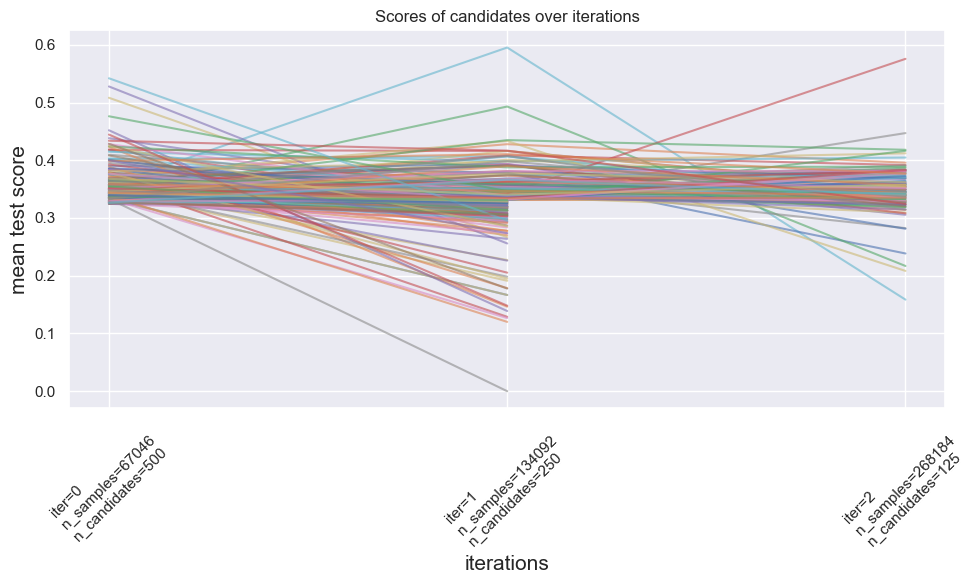

In [22]:
results = pd.DataFrame(halving_search_2.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={halving_search_2.n_resources_[i]}\nn_candidates={halving_search_2.n_candidates_[i]}"
    for i in range(halving_search_2.n_iterations_)
]

ax.set_xticks(range(halving_search_2.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.gcf().set_size_inches((10, 6))
plt.tight_layout()
plt.show()

In [23]:
mean_scores

params_str,"{'colsample_bytree': np.float64(0.5000950094303538), 'learning_rate': np.float64(0.5112837457460335), 'max_depth': 2, 'reg_alpha': np.float64(4.317203095538689), 'reg_lambda': np.float64(3.8963497073209963), 'subsample': np.float64(0.899173644213335)}","{'colsample_bytree': np.float64(0.5011525006662458), 'learning_rate': np.float64(0.9153740112523777), 'max_depth': 1, 'reg_alpha': np.float64(2.749513295711637), 'reg_lambda': np.float64(3.96653966044927), 'subsample': np.float64(0.8401392004479582)}","{'colsample_bytree': np.float64(0.5020580683018859), 'learning_rate': np.float64(0.89196815044486), 'max_depth': 1, 'reg_alpha': np.float64(3.7305247688748233), 'reg_lambda': np.float64(1.9822796881449247), 'subsample': np.float64(0.8271868096476249)}","{'colsample_bytree': np.float64(0.5036121616518201), 'learning_rate': np.float64(0.7530475800043632), 'max_depth': 1, 'reg_alpha': np.float64(2.2110835713250085), 'reg_lambda': np.float64(2.204022114784653), 'subsample': np.float64(0.8534838678643011)}","{'colsample_bytree': np.float64(0.5043350605921193), 'learning_rate': np.float64(0.9432291858515582), 'max_depth': 1, 'reg_alpha': np.float64(2.4579409127712446), 'reg_lambda': np.float64(4.350185901152415), 'subsample': np.float64(0.8802428587750224)}","{'colsample_bytree': np.float64(0.5056319290860338), 'learning_rate': np.float64(0.5193054424532831), 'max_depth': 3, 'reg_alpha': np.float64(3.870526621593617), 'reg_lambda': np.float64(3.317879924343034), 'subsample': np.float64(0.8705203514053397)}","{'colsample_bytree': np.float64(0.505726111066824), 'learning_rate': np.float64(0.8427217111369181), 'max_depth': 1, 'reg_alpha': np.float64(3.3987189920353025), 'reg_lambda': np.float64(1.7070886226635489), 'subsample': np.float64(0.502266325811827)}","{'colsample_bytree': np.float64(0.5068644407327001), 'learning_rate': np.float64(0.8580186538023465), 'max_depth': 1, 'reg_alpha': np.float64(2.920415312341697), 'reg_lambda': np.float64(2.0196056097300454), 'subsample': np.float64(0.6735406596951892)}","{'colsample_bytree': np.float64(0.5070209453466515), 'learning_rate': np.float64(0.5759851664683389), 'max_depth': 1, 'reg_alpha': np.float64(3.717079673363876), 'reg_lambda': np.float64(2.169790156515589), 'subsample': np.float64(0.7567439835421421)}","{'colsample_bytree': np.float64(0.5071447569913278), 'learning_rate': np.float64(0.8780786967184165), 'max_depth': 1, 'reg_alpha': np.float64(4.235508104879733), 'reg_lambda': np.float64(4.402533790841333), 'subsample': np.float64(0.5741835498706618)}",...,"{'colsample_bytree': np.float64(0.8927363553242125), 'learning_rate': np.float64(0.903360101241618), 'max_depth': 2, 'reg_alpha': np.float64(1.5915007498171483), 'reg_lambda': np.float64(1.6120445662476433), 'subsample': np.float64(0.8290402242638633)}","{'colsample_bytree': np.float64(0.8928673373317743), 'learning_rate': np.float64(0.7099815347626086), 'max_depth': 1, 'reg_alpha': np.float64(2.225556872701355), 'reg_lambda': np.float64(1.7793083034176975), 'subsample': np.float64(0.8588863031813307)}","{'colsample_bytree': np.float64(0.8929322060320326), 'learning_rate': np.float64(0.9305193868789018), 'max_depth': 3, 'reg_alpha': np.float64(4.211171901525812), 'reg_lambda': np.float64(4.467554729440077), 'subsample': np.float64(0.7973411291574497)}","{'colsample_bytree': np.float64(0.8929514467634425), 'learning_rate': np.float64(0.46722334130083143), 'max_depth': 2, 'reg_alpha': np.float64(3.22799525341698), 'reg_lambda': np.float64(4.252186839256595), 'subsample': np.float64(0.5021200025590422)}","{'colsample_bytree': np.float64(0.8932923543227154), 'learning_rate': np.float64(0.680057735948788), 'max_depth': 1, 'reg_alpha': np.float64(3.3226345557043153), 'reg_lambda': np.float64(2.0115723710618747), 'subsample': np.float64(0.5260206371941119)}","{'colsample_bytree': np.float64(0.8971859184477202), 'learning_rate': np.float64(0.44427793884123934), 'max_depth': 3, 'reg_alpha': np.float64(3.5862333693199426), 'reg_

In [24]:
results

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_reg_alpha,...,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score,params_str
0,0,67046,59.763001,2.350457,0.856385,0.253248,0.649816,0.970429,3,3.839073,...,0.360759,0.350511,0.031329,223,0.784464,0.716418,0.591542,0.697475,0.079891,{'colsample_bytree': np.float64(0.649816047538...
1,0,67046,56.314209,3.157131,1.104188,0.100677,0.539990,0.675549,1,3.303345,...,0.375000,0.363771,0.021768,140,0.440758,0.419708,0.434286,0.431584,0.008804,{'colsample_bytree': np.float64(0.539989966327...
2,0,67046,59.802440,4.123017,1.036675,0.113339,0.887964,0.899466,2,1.502336,...,0.317073,0.314829,0.035501,588,0.548387,0.666667,0.456790,0.557281,0.085912,{'colsample_bytree': np.float64(0.887963940864...
3,0,67046,55.896031,2.820627,1.033050,0.100824,0.744661,0.404240,1,2.373687,...,0.000000,0.000000,0.000000,863,0.666667,0.000000,0.562500,0.409722,0.292822,{'colsample_bytree': np.float64(0.744661264195...
4,0,67046,60.010263,4.173956,1.050149,0.038594,0.616858,0.619817,2,1.771819,...,0.346154,0.345821,0.069713,267,0.642157,0.567500,0.599198,0.602952,0.030594,{'colsample_bytree': np.float64(0.616857859414...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
870,2,268184,219.351117,9.518312,1.506508,0.145279,0.571799,0.852219,2,4.311685,...,0.376963,0.395778,0.026390,49,0.479879,0.477162,0.465271,0.474104,0.006344,{'colsample_bytree': np.float64(0.571798929369...
871,2,268184,211.946054,8.643544,1.418500,0.282895,0.697792,0.987731,1,3.462524,...,0.345070,0.208357,0.149706,795,0.349337,0.333333,0.382756,0.355142,0.020590,{'colsample_bytree': np.float64(0.697792452518...
872,2,268184,218.101810,8.729868,1.172940,0.228803,0.792332,0.493698,2,4.104427,...,0.432927,0.418118,0.131640,22,0.527426,0.421488,0.459307,0.469407,0.043835,{'colsample_bytree': np.float64(0.792331789948...
873,2,268184,209.816693,9.244005,1.438601,0.209682,0.595003,0.640134,1,1.748674,...,0.272727,0.216901,0.039494,788,0.351852,0.358779,0.391566,0.367399,0.017321,{'colsample_bytree': np.float64(0.595002588516...


### Select best mdl

Model trained.
Accuracy on training data: 0.7541165152803257
Accuracy on test data: 0.7192126514131898
For Model XGBoost: 
precision TRAIN: 0.372
% possible trades : 0.17
nb trade per day : 0.49
precision TEST: 0.226
% possible trades : 0.21
nb trade per day : 0.60


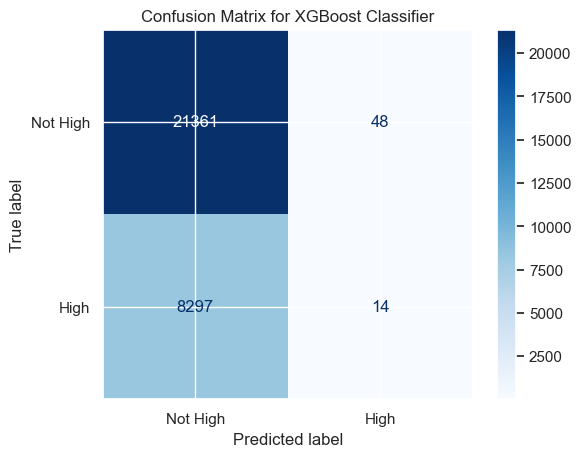

In [26]:
print("Model trained.")
print("Accuracy on training data:", best_model_2.score(df_combined_condition, y_comb))
print("Accuracy on test data:", best_model_2.score(df_combined_condition_test, y_comb_test))
arr_xgb_pred_train = best_model_2.predict(df_combined_condition)
arr_xgb_pred = best_model_2.predict(df_combined_condition_test)
cm = confusion_matrix(y_comb_test, arr_xgb_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Classifier")

print("For Model XGBoost: ")
print(f"precision TRAIN: {precision_score(y_comb, arr_xgb_pred_train):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred_train) / arr_xgb_pred_train.shape[0]:.2f}")
print(f"nb trade per day : {288*arr_xgb_pred_train.sum() / arr_xgb_pred_train.shape[0]:.2f}")
print(f"precision TEST: {precision_score(y_comb_test, arr_xgb_pred):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred) / arr_xgb_pred.shape[0]:.2f}")
# per day
print(f"nb trade per day : {288*arr_xgb_pred.sum() / arr_xgb_pred.shape[0]:.2f}")
plt.show()

In [27]:
halving_search_2.best_params_

{'colsample_bytree': np.float64(0.6484828375559993),
 'learning_rate': np.float64(0.6573321273166232),
 'max_depth': 1,
 'reg_alpha': np.float64(3.8301316708655437),
 'reg_lambda': np.float64(1.6960984726931558),
 'subsample': np.float64(0.6950284774693537)}

In [28]:
halving_search_2.best_index_

np.int64(794)

In [29]:
results.iloc[halving_search_2.best_index_]

iter                                                                      2
n_resources                                                          268184
mean_fit_time                                                    198.018834
std_fit_time                                                       7.507158
mean_score_time                                                    1.781525
std_score_time                                                     0.319277
param_colsample_bytree                                             0.648483
param_learning_rate                                                0.657332
param_max_depth                                                           1
param_reg_alpha                                                    3.830132
param_reg_lambda                                                   1.696098
param_subsample                                                    0.695028
params                    {'colsample_bytree': 0.6484828375559993, 'lear...
split0_test_

In [30]:
results.columns

Index(['iter', 'n_resources', 'mean_fit_time', 'std_fit_time',
       'mean_score_time', 'std_score_time', 'param_colsample_bytree',
       'param_learning_rate', 'param_max_depth', 'param_reg_alpha',
       'param_reg_lambda', 'param_subsample', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'mean_train_score',
       'std_train_score', 'params_str'],
      dtype='object')

In [31]:
results[results["rank_test_score"] == 1].iloc[0]["param_learning_rate"]

np.float64(0.4712907497608432)

In [104]:
bol_select_rank = (results["n_resources"]>200000) & (results["split2_train_score"]>0.47) & (results["split2_test_score"]>0.40)
list_col_rank =["n_resources", 'param_learning_rate', 'param_max_depth', 'param_reg_alpha',
       'param_reg_lambda', 'param_subsample', "param_colsample_bytree",'param_n_estimators',
       'split0_train_score', 'split1_train_score', 'split2_train_score',"std_train_score", 'mean_train_score',
       'split0_test_score', 'split1_test_score', 'split2_test_score',"std_test_score", 'mean_test_score',
       "mean_train_score", "rank_test_score"]


In [123]:
n_rank_select = 17
list_rank_split2_test_score = list(results[bol_select_rank].sort_values(by="split2_test_score", ascending=False).head(n_rank_select)["rank_test_score"].values)
list_rank_std_test_score = list(results[bol_select_rank].sort_values(by="std_test_score", ascending=True).head(n_rank_select)["rank_test_score"].values)
list_rank_split2_train_score = list(results[bol_select_rank].sort_values(by="split2_train_score", ascending=False).head(n_rank_select)["rank_test_score"].values)
list_std_train_score = list(results[bol_select_rank].sort_values(by="std_train_score", ascending=True).head(n_rank_select)["rank_test_score"].values)
# intersection of this list_df_test
list_intersection = list(set(list_rank_split2_test_score) & set(list_rank_std_test_score) & set(list_rank_split2_train_score) & set(list_std_train_score))
print("nb mdl in intersection:", len(list_intersection))
print("Intersection of rank lists:", list_intersection)

nb mdl in intersection: 14
Intersection of rank lists: [np.int32(96), np.int32(38), np.int32(70), np.int32(550), np.int32(9), np.int32(74), np.int32(138), np.int32(244), np.int32(564), np.int32(55), np.int32(89), np.int32(125), np.int32(158), np.int32(57)]


In [124]:
results[results["rank_test_score"].isin(list_intersection)].filter(items=list_col_rank).sort_values(by="split2_test_score", ascending=False)

,n_resources,param_learning_rate,param_max_depth,param_reg_alpha,param_reg_lambda,param_subsample,param_colsample_bytree,split0_train_score,split1_train_score,split2_train_score,std_train_score,mean_train_score,split0_test_score,split1_test_score,split2_test_score,std_test_score,mean_test_score,rank_test_score
859,268184,0.430957,2,1.618280,3.616726,0.870099,0.777270,0.515504,0.523677,0.522959,0.003695,0.520713,0.291667,0.384000,0.538462,0.101812,0.404709,38
853,268184,0.427634,2,2.465010,4.044126,0.791545,0.821901,0.507282,0.481481,0.485646,0.011309,0.491470,0.265152,0.214286,0.480769,0.115514,0.320069,550
829,268184,0.625756,3,2.945001,2.633963,0.782034,0.801351,0.612985,0.627451,0.615826,0.006258,0.618754,0.321603,0.372340,0.479730,0.065921,0.391224,57
865,268184,0.530952,2,3.893968,2.276948,0.735422,0.771859,0.616327,0.572565,0.529118,0.035603,0.572670,0.253165,0.449153,0.472727,0.098418,0.391681,55
816,268184,0.516564,2,3.887378,4.170016,0.635198,0.751158,0.471084,0.464935,0.521739,0.025452,0.485920,0.290780,0.316456,0.471910,0.080023,0.359715,158
808,268184,0.536362,2,3.261185,2.005333,0.757030,0.649301,0.507788,0.470383,0.525903,0.023117,0.501358,0.302583,0.368254,0.432099,0.052876,0.367645,125
805,268184,0.657794,3,2.630742,2.885198,0.692362,0.603719,0.655937,0.654822,0.603134,0.024633,0.637964,0.286730,0.418006,0.432000,0.065433,0.378912,89
791,268184,0.926477,3,2.318878,2.930030,0.517751,0.536595,0.621118,0.510200,0.550531,0.045840,0.560616,0.330855,0.391181,0.430508,0.040983,0.384181,70
784,268184,0.511080,2,4.374512,3.775177,0.755580,0.678402,0.545455,0.464968,0.521472,0.033741,0.510632,0.372093,0.549020,0.420000,0.074717,0.447038,9
769,268184,0.598152,2,2.977875,1.534061,0.687464,0.599490,0.472050,0.485099,0.509634,0.015581,0.488928,0.295775,0.433526,0.419643,0.061924,0.382981,74


In [110]:
results[bol_select_rank].filter(items=list_col_rank).sort_values(by="std_test_score", ascending=True).head(20)

,n_resources,param_learning_rate,param_max_depth,param_reg_alpha,param_reg_lambda,param_subsample,param_colsample_bytree,split0_train_score,split1_train_score,split2_train_score,std_train_score,mean_train_score,split0_test_score,split1_test_score,split2_test_score,std_test_score,mean_test_score,rank_test_score
762,268184,0.906549,3,1.513090,2.000859,0.785218,0.872068,0.665438,0.491989,0.576426,0.070818,0.577951,0.360000,0.387464,0.402098,0.017450,0.383187,72
791,268184,0.926477,3,2.318878,2.930030,0.517751,0.536595,0.621118,0.510200,0.550531,0.045840,0.560616,0.330855,0.391181,0.430508,0.040983,0.384181,70
861,268184,0.692577,2,2.341003,3.562219,0.509799,0.535442,0.552434,0.539816,0.473837,0.034464,0.522029,0.308642,0.390805,0.407407,0.043180,0.368951,119
770,268184,0.738905,2,2.382134,3.642178,0.711059,0.688827,0.560606,0.455344,0.478485,0.045166,0.498145,0.303797,0.410959,0.413793,0.051197,0.376183,101
808,268184,0.536362,2,3.261185,2.005333,0.757030,0.649301,0.507788,0.470383,0.525903,0.023117,0.501358,0.302583,0.368254,0.432099,0.052876,0.367645,125
758,268184,0.732281,3,3.975858,2.339111,0.876955,0.874783,0.660228,0.633706,0.623608,0.015443,0.639181,0.301216,0.423888,0.407407,0.054361,0.377504,96
817,268184,0.517668,3,1.559132,1.812326,0.819966,0.601555,0.633996,0.662791,0.639962,0.012409,0.645583,0.275964,0.354497,0.415842,0.057248,0.348768,244
769,268184,0.598152,2,2.977875,1.534061,0.687464,0.599490,0.472050,0.485099,0.509634,0.015581,0.488928,0.295775,0.433526,0.419643,0.061924,0.382981,74
805,268184,0.657794,3,2.630742,2.885198,0.692362,0.603719,0.655937,0.654822,0.603134,0.024633,0.637964,0.286730,0.418006,0.432000,0.065433,0.378912,89
829,268184,0.625756,3,2.945001,2.633963,0.782034,0.801351,0.612985,0.627451,0.615826,0.006258,0.618754,0.321603,0.372340,0.479730,0.065921,0.391224,57


In [113]:
results[bol_select_rank].filter(items=list_col_rank).sort_values(by="std_train_score", ascending=True).head(20)

,n_resources,param_learning_rate,param_max_depth,param_reg_alpha,param_reg_lambda,param_subsample,param_colsample_bytree,split0_train_score,split1_train_score,split2_train_score,std_train_score,mean_train_score,split0_test_score,split1_test_score,split2_test_score,std_test_score,mean_test_score,rank_test_score
859,268184,0.430957,2,1.618280,3.616726,0.870099,0.777270,0.515504,0.523677,0.522959,0.003695,0.520713,0.291667,0.384000,0.538462,0.101812,0.404709,38
829,268184,0.625756,3,2.945001,2.633963,0.782034,0.801351,0.612985,0.627451,0.615826,0.006258,0.618754,0.321603,0.372340,0.479730,0.065921,0.391224,57
853,268184,0.427634,2,2.465010,4.044126,0.791545,0.821901,0.507282,0.481481,0.485646,0.011309,0.491470,0.265152,0.214286,0.480769,0.115514,0.320069,550
817,268184,0.517668,3,1.559132,1.812326,0.819966,0.601555,0.633996,0.662791,0.639962,0.012409,0.645583,0.275964,0.354497,0.415842,0.057248,0.348768,244
759,268184,0.471002,2,4.473379,3.741659,0.795995,0.814261,0.546053,0.558692,0.582759,0.015225,0.562501,0.244784,0.460674,0.543478,0.125911,0.416312,26
758,268184,0.732281,3,3.975858,2.339111,0.876955,0.874783,0.660228,0.633706,0.623608,0.015443,0.639181,0.301216,0.423888,0.407407,0.054361,0.377504,96
769,268184,0.598152,2,2.977875,1.534061,0.687464,0.599490,0.472050,0.485099,0.509634,0.015581,0.488928,0.295775,0.433526,0.419643,0.061924,0.382981,74
808,268184,0.536362,2,3.261185,2.005333,0.757030,0.649301,0.507788,0.470383,0.525903,0.023117,0.501358,0.302583,0.368254,0.432099,0.052876,0.367645,125
805,268184,0.657794,3,2.630742,2.885198,0.692362,0.603719,0.655937,0.654822,0.603134,0.024633,0.637964,0.286730,0.418006,0.432000,0.065433,0.378912,89
816,268184,0.516564,2,3.887378,4.170016,0.635198,0.751158,0.471084,0.464935,0.521739,0.025452,0.485920,0.290780,0.316456,0.471910,0.080023,0.359715,158


In [114]:
results[bol_select_rank].filter(items=list_col_rank).sort_values(by="split2_test_score", ascending=False).head(20)

,n_resources,param_learning_rate,param_max_depth,param_reg_alpha,param_reg_lambda,param_subsample,param_colsample_bytree,split0_train_score,split1_train_score,split2_train_score,std_train_score,mean_train_score,split0_test_score,split1_test_score,split2_test_score,std_test_score,mean_test_score,rank_test_score
759,268184,0.471002,2,4.473379,3.741659,0.795995,0.814261,0.546053,0.558692,0.582759,0.015225,0.562501,0.244784,0.460674,0.543478,0.125911,0.416312,26
859,268184,0.430957,2,1.618280,3.616726,0.870099,0.777270,0.515504,0.523677,0.522959,0.003695,0.520713,0.291667,0.384000,0.538462,0.101812,0.404709,38
844,268184,0.675549,1,3.303345,3.624218,0.508234,0.539990,0.343373,0.331633,0.517857,0.085155,0.397621,0.000000,0.416667,0.500000,0.218722,0.305556,644
853,268184,0.427634,2,2.465010,4.044126,0.791545,0.821901,0.507282,0.481481,0.485646,0.011309,0.491470,0.265152,0.214286,0.480769,0.115514,0.320069,550
829,268184,0.625756,3,2.945001,2.633963,0.782034,0.801351,0.612985,0.627451,0.615826,0.006258,0.618754,0.321603,0.372340,0.479730,0.065921,0.391224,57
865,268184,0.530952,2,3.893968,2.276948,0.735422,0.771859,0.616327,0.572565,0.529118,0.035603,0.572670,0.253165,0.449153,0.472727,0.098418,0.391681,55
816,268184,0.516564,2,3.887378,4.170016,0.635198,0.751158,0.471084,0.464935,0.521739,0.025452,0.485920,0.290780,0.316456,0.471910,0.080023,0.359715,158
808,268184,0.536362,2,3.261185,2.005333,0.757030,0.649301,0.507788,0.470383,0.525903,0.023117,0.501358,0.302583,0.368254,0.432099,0.052876,0.367645,125
805,268184,0.657794,3,2.630742,2.885198,0.692362,0.603719,0.655937,0.654822,0.603134,0.024633,0.637964,0.286730,0.418006,0.432000,0.065433,0.378912,89
791,268184,0.926477,3,2.318878,2.930030,0.517751,0.536595,0.621118,0.510200,0.550531,0.045840,0.560616,0.330855,0.391181,0.430508,0.040983,0.384181,70


In [115]:
results[bol_select_rank].filter(items=list_col_rank).sort_values(by="split2_train_score", ascending=False).head(20)

,n_resources,param_learning_rate,param_max_depth,param_reg_alpha,param_reg_lambda,param_subsample,param_colsample_bytree,split0_train_score,split1_train_score,split2_train_score,std_train_score,mean_train_score,split0_test_score,split1_test_score,split2_test_score,std_test_score,mean_test_score,rank_test_score
817,268184,0.517668,3,1.559132,1.812326,0.819966,0.601555,0.633996,0.662791,0.639962,0.012409,0.645583,0.275964,0.354497,0.415842,0.057248,0.348768,244
758,268184,0.732281,3,3.975858,2.339111,0.876955,0.874783,0.660228,0.633706,0.623608,0.015443,0.639181,0.301216,0.423888,0.407407,0.054361,0.377504,96
829,268184,0.625756,3,2.945001,2.633963,0.782034,0.801351,0.612985,0.627451,0.615826,0.006258,0.618754,0.321603,0.372340,0.479730,0.065921,0.391224,57
805,268184,0.657794,3,2.630742,2.885198,0.692362,0.603719,0.655937,0.654822,0.603134,0.024633,0.637964,0.286730,0.418006,0.432000,0.065433,0.378912,89
759,268184,0.471002,2,4.473379,3.741659,0.795995,0.814261,0.546053,0.558692,0.582759,0.015225,0.562501,0.244784,0.460674,0.543478,0.125911,0.416312,26
762,268184,0.906549,3,1.513090,2.000859,0.785218,0.872068,0.665438,0.491989,0.576426,0.070818,0.577951,0.360000,0.387464,0.402098,0.017450,0.383187,72
791,268184,0.926477,3,2.318878,2.930030,0.517751,0.536595,0.621118,0.510200,0.550531,0.045840,0.560616,0.330855,0.391181,0.430508,0.040983,0.384181,70
865,268184,0.530952,2,3.893968,2.276948,0.735422,0.771859,0.616327,0.572565,0.529118,0.035603,0.572670,0.253165,0.449153,0.472727,0.098418,0.391681,55
808,268184,0.536362,2,3.261185,2.005333,0.757030,0.649301,0.507788,0.470383,0.525903,0.023117,0.501358,0.302583,0.368254,0.432099,0.052876,0.367645,125
859,268184,0.430957,2,1.618280,3.616726,0.870099,0.777270,0.515504,0.523677,0.522959,0.003695,0.520713,0.291667,0.384000,0.538462,0.101812,0.404709,38


In [125]:
list_intersection

[np.int32(96),
 np.int32(38),
 np.int32(70),
 np.int32(550),
 np.int32(9),
 np.int32(74),
 np.int32(138),
 np.int32(244),
 np.int32(564),
 np.int32(55),
 np.int32(89),
 np.int32(125),
 np.int32(158),
 np.int32(57)]

### Best MDLs Long run 

In [129]:
mode_redo = True

In [131]:
r_period_test = 1/ (y_comb_test.shape[0]/(30*288))
r_period_train = 1/ (y_comb.shape[0]/(30*288))

In [ ]:
nb_rounds = 4000
#gain_period_min_mdl = 600
df_hcv = None
for rank_best in list_intersection: # 258min for 14 mdls on PC (2000 rounds = 18min)
    print(f"\n--- Training/Evaluating Model for Rank {rank_best} ---")
    params_ = {
        'colsample_bytree': results[results["rank_test_score"] == rank_best].iloc[0]["param_colsample_bytree"],
        'learning_rate': results[results["rank_test_score"] == rank_best].iloc[0]["param_learning_rate"],
        'max_depth': results[results["rank_test_score"] == rank_best].iloc[0]["param_max_depth"],
        'reg_alpha': results[results["rank_test_score"] == rank_best].iloc[0]["param_reg_alpha"],
        'reg_lambda': results[results["rank_test_score"] == rank_best].iloc[0]["param_reg_lambda"],
        'subsample': results[results["rank_test_score"] == rank_best].iloc[0]["param_subsample"],
    }
    print(params_)

    if mode_redo:
        # n 100 : 14.875
        xgb_mdl_long = xgb.XGBClassifier(
            device='cuda',
            verbosity=0,
            objective="binary:hinge",
            random_state=42,
            n_jobs=-1,
            #use_label_encoder=False, # Recommended to avoid a future warning
            eval_metric=fun_nb_trade_fixed_window, #fun_trades_gain, #[fun_nb_trade_fixed_window, precision_score], #, # A common metric for binary classification
            max_depth=params_['max_depth'],
            learning_rate=params_['learning_rate'],
            subsample=params_['subsample'],
            colsample_bytree=params_['colsample_bytree'],
            reg_alpha=params_['reg_alpha'],
            reg_lambda=params_['reg_lambda'],
            #scale_pos_weight=1.5,  # ajuster si classes déséquilibrées
            n_estimators=nb_rounds,#400+59+1,
        )
        xgb_mdl_long.fit(
            df_combined_condition, 
            y_comb, 
            eval_set=[(df_combined_condition_test, y_comb_test), (df_combined_condition, y_comb)],
            verbose=100,
        )
        print("Model trained.")
        # save xgb_mdl_long
        with open(os.path.join(path_data,f"xgb_mdl_14_rank{rank_best}_round{nb_rounds}.pkl"), 'wb') as f:
            pickle.dump(xgb_mdl_long, f)
    else:
        # load  xgb_mdl
        xgb_mdl_long = pickle.load(open(os.path.join(path_data,f"xgb_mdl_14_rank{rank_best}_round{nb_rounds}.pkl"), 'rb'))
        print("Model loaded.")

    print("Accuracy on training data:", xgb_mdl_long.score(df_combined_condition, y_comb))
    print("Accuracy on test data:", xgb_mdl_long.score(df_combined_condition_test, y_comb_test))
    arr_xgb_pred_train = xgb_mdl_long.predict(df_combined_condition)
    arr_xgb_pred = xgb_mdl_long.predict(df_combined_condition_test)
    cm = confusion_matrix(y_comb_test, arr_xgb_pred, labels=[False, True])
    print(cm)
    print("For Model XGBoost: ")
    print(f"precision TRAIN: {precision_score(y_comb, arr_xgb_pred_train):.3f}")
    print(f"% possible trades : {100*np.sum(arr_xgb_pred_train) / arr_xgb_pred_train.shape[0]:.2f}")
    print(f"nb trade per day : {288*arr_xgb_pred_train.sum() / arr_xgb_pred_train.shape[0]:.2f}")
    print(f"precision TEST: {precision_score(y_comb_test, arr_xgb_pred):.3f}")
    print(f"% possible trades : {100*np.sum(arr_xgb_pred) / arr_xgb_pred.shape[0]:.2f}")
    # per day
    print(f"nb trade per day : {288*arr_xgb_pred.sum() / arr_xgb_pred.shape[0]:.2f}")
    
    arr_eval = xgb_mdl_long.evals_result_["validation_0"]
    arr_eval_train = xgb_mdl_long.evals_result_["validation_1"]
    arr_eval_nb_trade, arr_eval_precision = fun_decoded_nb_trade_fixed_window(np.array(arr_eval["fun_nb_trade_fixed_window"]))
    arr_eval_nb_trade_train, arr_eval_precision_train = fun_decoded_nb_trade_fixed_window(
        np.array(arr_eval_train["fun_nb_trade_fixed_window"])
    )
    arr_eval_gain = fun_arr_trade(arr_eval_nb_trade, arr_eval_precision, risk=risk, R=R_eq)
    arr_eval_gain_train = fun_arr_trade(arr_eval_nb_trade_train, arr_eval_precision_train, risk=risk, R=R_eq)

    df = pd.DataFrame({
        'trades_train': arr_eval_nb_trade_train*r_period_train,
        'precision_train': arr_eval_precision_train,
        'gain_train': arr_eval_gain_train*r_period_train,
        'trades_test': arr_eval_nb_trade*r_period_test,
        'precision_test': arr_eval_precision,
        'gain_test': arr_eval_gain*r_period_test,
    })
    df['run_index'] = df.index

    print("nb good mdl : ", df[(df["gain_train"] > gain_period_min) & (df["gain_test"] > gain_period_min)].shape[0])
    df_good = df.copy()[(df["gain_train"] > gain_period_min) & (df["gain_test"] > gain_period_min)]

    if df_good.shape[0] == 0:
        print("No good models found for this rank.")
        continue

    df_good["rank"] = rank_best
    df_good["max_depth"] = params_['max_depth']
    df_good["learning_rate"] = params_['learning_rate']
    df_good["subsample"] = params_['subsample']
    df_good["colsample_bytree"] = params_['colsample_bytree']
    df_good["reg_alpha"] = params_['reg_alpha']
    df_good["reg_lambda"] = params_['reg_lambda']

    if df_hcv is None:
        df_hcv = df_good.copy()
    else:
        df_hcv = pd.concat([df_hcv, df_good], axis=0)
    # save 
    df_hcv.to_csv(os.path.join(
        path_data,
        f"df_hcv_xgb_14_{
            df_combined_condition.index.max().strftime("%Y-%m-%d")
        }_{
            df_combined_condition_test.index.max().strftime("%Y-%m-%d")
        }.csv",
    ))

{'colsample_bytree': np.float64(0.8747831292124251), 'learning_rate': np.float64(0.7322813444274258), 'max_depth': np.int64(3), 'reg_alpha': np.float64(3.9758583246986907), 'reg_lambda': np.float64(2.3391106154144374), 'subsample': np.float64(0.8769548076408933)}
[0]	validation_0-error:0.27964	validation_0-fun_nb_trade_fixed_window:0.00000	validation_1-error:0.24541	validation_1-fun_nb_trade_fixed_window:960.51497
[100]	validation_0-error:0.28069	validation_0-fun_nb_trade_fixed_window:980.42289	validation_1-error:0.24512	validation_1-fun_nb_trade_fixed_window:8730.52497
[200]	validation_0-error:0.28338	validation_0-fun_nb_trade_fixed_window:1390.33233	validation_1-error:0.24477	validation_1-fun_nb_trade_fixed_window:10790.53736
[300]	validation_0-error:0.28254	validation_0-fun_nb_trade_fixed_window:1090.31624	validation_1-error:0.24430	validation_1-fun_nb_trade_fixed_window:11870.56106
[400]	validation_0-error:0.28136	validation_0-fun_nb_trade_fixed_window:630.31915	validation_1-error:

#### Results

In [ ]:
df_hcv = pd.read_csv(
    os.path.join(
        path_data,
        f"df_hcv_xgb_14_{
            df_combined_condition.index.max().strftime("%Y-%m-%d")
        }_{
            df_combined_condition_test.index.max().strftime("%Y-%m-%d")
        }.csv",
    ),
    index_col=0,
)

In [187]:
df_hcv

,trades_train,precision_train,gain_train,trades_test,precision_test,gain_test,rank,run_index,max_depth,learning_rate,subsample,colsample_bytree,reg_alpha,reg_lambda
98,21.133831,0.538577,1062.116154,26.745626,0.484211,533.511915,96,98,3,0.732281,0.876955,0.874783,3.975858,2.339111
37,13.788536,0.500620,401.186429,13.954240,0.500000,401.184388,70,37,3,0.926477,0.517751,0.536595,2.318878,2.930030
571,21.166048,0.481638,391.850957,17.733513,0.483051,342.273333,564,571,2,0.779524,0.841754,0.740742,4.414185,2.042931
572,15.721509,0.500000,451.993378,11.047106,0.511905,390.924366,564,572,2,0.779524,0.841754,0.740742,4.414185,2.042931
607,17.557833,0.490163,408.498294,12.791386,0.500000,367.752355,564,607,2,0.779524,0.841754,0.740742,4.414185,2.042931
623,19.941832,0.497386,544.266334,16.279946,0.486957,349.669271,564,623,2,0.779524,0.841754,0.740742,4.414185,2.042931
343,12.467672,0.496799,336.196291,9.012113,0.529412,406.871580,55,343,2,0.530952,0.735422,0.771859,3.893968,2.276948
346,11.307888,0.504788,355.286054,9.302826,0.545455,503.200693,55,346,2,0.530952,0.735422,0.771859,3.893968,2.276948
390,12.693185,0.496350,339.100034,11.047106,0.506667,358.664772,55,390,2,0.530952,0.735422,0.771859,3.893968,2.276948


In [146]:
def get_df_xgb_rounds_eval(xgb_mdl_long, risk, R_eq, r_period_train, r_period_test):
    arr_eval = xgb_mdl_long.evals_result_["validation_0"]
    arr_eval_train = xgb_mdl_long.evals_result_["validation_1"]
    arr_eval_nb_trade, arr_eval_precision = fun_decoded_nb_trade_fixed_window(np.array(arr_eval["fun_nb_trade_fixed_window"]))
    arr_eval_nb_trade_train, arr_eval_precision_train = fun_decoded_nb_trade_fixed_window(
        np.array(arr_eval_train["fun_nb_trade_fixed_window"])
    )
    arr_eval_gain = fun_arr_trade(arr_eval_nb_trade, arr_eval_precision, risk=risk, R=R_eq)
    arr_eval_gain_train = fun_arr_trade(arr_eval_nb_trade_train, arr_eval_precision_train, risk=risk, R=R_eq)

    df = pd.DataFrame({
        'trades_train': arr_eval_nb_trade_train*r_period_train,
        'precision_train': arr_eval_precision_train,
        'gain_train': arr_eval_gain_train*r_period_train,
        'trades_test': arr_eval_nb_trade*r_period_test,
        'precision_test': arr_eval_precision,
        'gain_test': arr_eval_gain*r_period_test,
    })
    df['run_index'] = df.index
    return df

#### Plots rounds

In [151]:
df_hcv["rank"].unique()

array([ 96,  70, 564,  55], dtype=int32)

In [154]:
for rank in df_hcv["rank"].unique():
    print(f"\n--- Plotting for Rank {rank} ---")
    xgb_mdl_long = pickle.load(open(os.path.join(path_data,f"xgb_mdl_14_rank{rank}_round{nb_rounds}.pkl"), 'rb'))
    df = get_df_xgb_rounds_eval(xgb_mdl_long, risk, R_eq, r_period_train, r_period_test)
    fun_plot_xgb_rounds(df, gain_period_min=gain_period_min, gain_period_bingo=gain_period_bingo)


--- Plotting for Rank 96 ---



--- Plotting for Rank 70 ---



--- Plotting for Rank 564 ---



--- Plotting for Rank 55 ---


In [148]:
#fun_plot_pre_trade(df.head(2000))

### Backtest

In [57]:
y_comb_1d = y_comb.resample("h").apply(sum_upfront_1h).resample("D").sum()
print(f"Nb possible trades high on Train: {y_comb_1d.sum()} / {y_comb_1d.shape[0]} days")
print(f"Nb of possible trade per day ; {y_comb_1d.sum() / y_comb_1d.shape[0]:.2f}")
print(f"5-min samples leading to a high trade {y_comb_1d.sum() / y_comb.shape[0] * 100:.2f} % ")

Nb possible trades high on Train: 13902 / 932 days
Nb of possible trade per day ; 14.92
5-min samples leading to a high trade 5.18 % 


In [49]:
df_feat_tot = pd.concat((list_df[0], list_df_test[0]))

#### Baseline

target level for TP [-]:  0.0045
R TP/SL [-]:  2
r_fees %fees/%TP [-]:  0.17200000000000001
R_eq [-]:  1.2321428571428572
leverage [-]:  8.269576962347873
Gain for one TP [$]:  307.9804229342824
Loss for one SL [$]:  -250.0
Capital init [$] 10000
final capital [$]: -2794488.301003885
ratio gain final [-]:  -280.4488301003885
Winrate [-] :  0.29361825485567566
nb_tp:  14180
capital_tp [$]:  4367162.397206699
nb_sl:  28946
capital_sl [$]:  -7236500.0
nb_neutral:  5168
capital_neutral [$] 64849.30178884704


,type,date_open,buy,sell,gain,fees,capital
2023-01-01 01:15:00,Neutral,2023-01-01 00:00:00,1194.540039,1194.369995,-75.773794,64.001970,9.924226e+03
2023-01-01 02:40:00,Neutral,2023-01-01 01:20:00,1193.660034,1195.109985,36.406005,64.045400,9.960632e+03
2023-01-01 04:05:00,Neutral,2023-01-01 02:45:00,1194.290039,1196.010010,55.042660,64.052616,1.001567e+04
2023-01-01 05:30:00,Neutral,2023-01-01 04:10:00,1195.829956,1196.160034,-41.189318,64.015359,9.974486e+03
2023-01-01 06:55:00,Neutral,2023-01-01 05:35:00,1196.170044,1197.160034,4.408765,64.033013,9.978894e+03
...,...,...,...,...,...,...,...
2025-10-31 14:05:00,SL,2025-10-31 13:55:00,3891.370000,3882.614417,-250.000000,63.934518,-2.794046e+06
2025-10-31 14:45:00,SL,2025-10-31 14:10:00,3883.090000,3874.353048,-250.000000,63.934518,-2.794296e+06
2025-10-31 14:55:00,SL,2025-10-31 14:50:00,3878.430000,3869.703532,-250.000000,63.934518,-2.794546e+06
2025-10-31 15:10:00,SL,2025-10-31 15:00:00,3861.080000,3852.392570,-250.000000,63.934518,-2.794796e+06


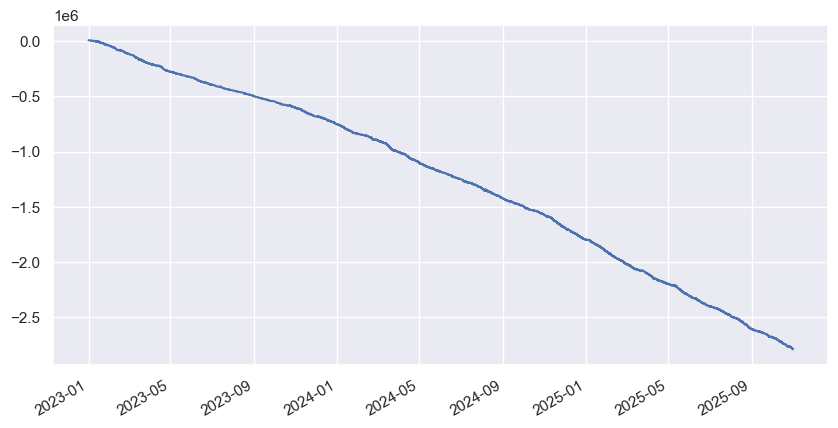

In [50]:
# 
capital_init = 10000
# strategy
step_max = FUTURE_TARGET # 1h15
tp_ratio = target_level #0.45/100 #0.1 / 100 #0.33/100
risk_ratio = 2.5/100

# trading platform
ratio_fees = 0.0774 / 100 # hyperliquid

# display
print("target level for TP [-]: ", tp_ratio)
print("R TP/SL [-]: ", R)
print("r_fees %fees/%TP [-]: ", ratio_fees / tp_ratio)
R_eq = (tp_ratio - ratio_fees) / ((tp_ratio / R) + ratio_fees)
print("R_eq [-]: ", R_eq)

def backtest(df_, capital_init, step_max, 
             tp_ratio, risk_ratio, ratio_fees, R,
             trade_signal=None):
    # leverage calculation 
    #leverage = (capital_init * risk_ratio * R / tp_ratio) / capital_init
    leverage = risk_ratio /  (tp_ratio / R + ratio_fees * (1 - tp_ratio / (2 * R)))
    print('leverage [-]: ', leverage)

    # TP calculation
    fees_tp = ((1+tp_ratio) + 1) / 2 * leverage * capital_init * ratio_fees
    gain_tp = tp_ratio * leverage * capital_init - fees_tp
    # SL calculation
    fees_sl = (1 + 1-1/R*tp_ratio) / 2 * leverage * capital_init * ratio_fees
    gain_sl = -1/R*tp_ratio * leverage * capital_init - fees_sl
    print("Gain for one TP [$]: ", gain_tp)
    print("Loss for one SL [$]: ", gain_sl)
    # simulation: initialisation
    if trade_signal is None:
        buy = df_["Close_ETH_raw"].values[0] # for first trade
        list_buy = [buy]
        list_trade_date_open = [df_["Close_ETH_raw"].index[0]]
        neutral = False
    else:
        list_buy = []
        list_trade_date_open = []
        neutral = True
    tp = False
    nb_tp = 0
    capital_tp = 0
    sl = False
    nb_sl = 0
    capital_sl = 0
    
    nb_neutral = 0
    capital_neutral = 0
    capital = capital_init
    step = 0
    list_trade_gain = []
    list_trade_date = []
    list_trade_type = []
    list_trade_fees = []
    list_capital = []
    list_sell = []
    
    #list_buy.append(buy)
    # simulation calculation
    for close, high, low, date_trade in zip(
            df_["Close_ETH_raw"], 
            df_["Close_ETH_raw"] * df_["High_ETH"], 
            df_["Close_ETH_raw"] * df_["Low_ETH"],
            df_["Close_ETH_raw"].index
        ):
        
        # NEUTRAL : if elasted time to take a trade is over (more than 1 hour) : we close the position
        if step >= step_max:
            nb_neutral += 1
            fees = ( (buy + close) / 2 ) / buy * leverage * capital_init * ratio_fees
            gain = ((close - buy) / buy) * leverage * capital_init - fees
            list_trade_fees.append(fees)
            list_trade_gain.append(gain)
            list_trade_date.append(date_trade)
            list_sell.append(close)
            list_trade_type.append("Neutral")
            capital += gain
            list_capital.append(capital)
            capital_neutral += gain
            neutral = True
            step = 0
            continue

        # if trade_signal is not None:
        #     if trade_signal.at[date_trade] == True:
        #         print("Trade possible at ", date_trade)

        # if last time, we have close a position or no trade opened
        if tp or sl or neutral:
            if trade_signal is not None:
                try:
                    if trade_signal.at[date_trade] == True:
                        pass
                except:
                    print(date_trade, "is not in trade_signal")

            # if no signal used,  we open a new one immediatly (5 min after)
            if trade_signal is None:
                buy = close
                list_trade_date_open.append(date_trade)
                list_buy.append(buy)
                step = 0
                tp = False
                sl = False
                neutral = False
                continue # trade done at close
            # if trade signal is True
            elif np.any(trade_signal.at[date_trade]):
                #print("Trade opened at ", date_trade)
                buy = close
                list_trade_date_open.append(date_trade)
                list_buy.append(buy)
                step = 0
                tp = False
                sl = False
                neutral = False
                continue # trade done at close
            # if no trade signal => no trade opened
            else:
                tp = False
                sl = False
                neutral = True # to be able to check next time
                step = 0
                continue
        # TP : if max price is higher than TP, we take the trade and close position
        if high >= (1+tp_ratio) * buy:
            fees = fees_tp
            gain = gain_tp
            list_trade_fees.append(fees)
            list_trade_gain.append(gain)
            list_trade_date.append(date_trade)
            list_sell.append((1+tp_ratio)*buy)
            list_trade_type.append("TP")
            capital += gain
            list_capital.append(capital)
            capital_tp += gain
            tp = True
            nb_tp += 1
            continue
        # SL : if min price is lower than SL, we take the trade and close position
        elif low <= (1-1/R*tp_ratio) * buy: 
            fees = fees_sl
            gain = gain_sl
            list_trade_fees.append(fees)
            list_trade_gain.append(gain)
            list_trade_date.append(date_trade)
            list_sell.append((1-1/R*tp_ratio)*buy)
            list_trade_type.append("SL")
            capital +=  gain
            list_capital.append(capital)
            capital_sl +=  gain
            sl = True
            nb_sl += 1
            continue
        # no trade
        else:
            step += 1
    # results
    if trade_signal is not None:
        print("trade signal used, adding last buy & date_open")
        list_trade_date_open.append(df_["Close_ETH_raw"].index[-1])
        #list_buy.append(buy)
    if len(list_buy) > len(list_trade_date):
        list_buy = list_buy[:len(list_trade_date)]
    if len(list_trade_date_open) > len(list_trade_date):
        list_trade_date_open = list_trade_date_open[:len(list_trade_date)]
    df_trades = pd.concat([
        pd.Series(list_trade_type, index=list_trade_date, name="type"),
        pd.Series(list_trade_date_open, index=list_trade_date, name="date_open"),
        pd.Series(list_buy, index=list_trade_date, name="buy"),
        pd.Series(list_sell, index=list_trade_date, name="sell"),
        pd.Series(list_trade_gain, index=list_trade_date, name="gain"),
        pd.Series(list_trade_fees, index=list_trade_date, name="fees"),
        pd.Series(list_capital, index=list_trade_date, name="capital"),
        ],
        axis=1,
    )
    return df_trades, capital, nb_tp, nb_sl, nb_neutral, capital_tp, capital_sl, capital_neutral

df_trades, capital, nb_tp, nb_sl, nb_neutral, capital_tp, capital_sl, capital_neutral = (
    backtest(df_feat_tot, capital_init, step_max, tp_ratio, risk_ratio, ratio_fees, R)
)

print("Capital init [$]", capital_init)
print('final capital [$]:', capital)
print("ratio gain final [-]: ", (capital - capital_init)/capital_init)
print("Winrate [-] : ", nb_tp / (nb_tp + nb_sl + nb_neutral))
print("nb_tp: ", nb_tp)
print('capital_tp [$]: ', capital_tp)
print("nb_sl: ", nb_sl)
print('capital_sl [$]: ', capital_sl)
print('nb_neutral: ', nb_neutral)
print('capital_neutral [$]', capital_neutral)

# final capital [$]: -2794488.301003885 # baseline
df_trades["capital"].plot(kind="line", figsize=(10, 5))
df_trades

#### All best mdls

In [155]:
df_hcv

,trades_train,precision_train,gain_train,trades_test,precision_test,gain_test,rank,run_index,max_depth,learning_rate,subsample,colsample_bytree,reg_alpha,reg_lambda
98,21.133831,0.538577,1062.116154,26.745626,0.484211,533.511915,96,98,3,0.732281,0.876955,0.874783,3.975858,2.339111
37,13.788536,0.500620,401.186429,13.954240,0.500000,401.184388,70,37,3,0.926477,0.517751,0.536595,2.318878,2.930030
571,21.166048,0.481638,391.850957,17.733513,0.483051,342.273333,564,571,2,0.779524,0.841754,0.740742,4.414185,2.042931
572,15.721509,0.500000,451.993378,11.047106,0.511905,390.924366,564,572,2,0.779524,0.841754,0.740742,4.414185,2.042931
607,17.557833,0.490163,408.498294,12.791386,0.500000,367.752355,564,607,2,0.779524,0.841754,0.740742,4.414185,2.042931
623,19.941832,0.497386,544.266334,16.279946,0.486957,349.669271,564,623,2,0.779524,0.841754,0.740742,4.414185,2.042931
343,12.467672,0.496799,336.196291,9.012113,0.529412,406.871580,55,343,2,0.530952,0.735422,0.771859,3.893968,2.276948
346,11.307888,0.504788,355.286054,9.302826,0.545455,503.200693,55,346,2,0.530952,0.735422,0.771859,3.893968,2.276948
390,12.693185,0.496350,339.100034,11.047106,0.506667,358.664772,55,390,2,0.530952,0.735422,0.771859,3.893968,2.276948


In [ ]:
mode_redo = False # re-train mdl

In [ ]:
df_hcv['bt_gain_train'] = np.nan
df_hcv['bt_nb_days_for_trade_train'] =np.nan
df_hcv['bt_gain_test'] = np.nan
df_hcv['bt_nb_days_for_trade_test'] = np.nan
df_hcv["bt_gain_month_train"] = np.nan
df_hcv["bt_gain_month_test"] = np.nan

for I in range(df_hcv.shape[0]):
    nb_rounds = int(df_hcv.iloc[I]["run_index"])
    rank_best = int(df_hcv.iloc[I]["rank"])
    print("\n\n--- Training model [rank={}] for round: {} ---\n".format(rank_best, nb_rounds))
    #xgb_mdl_long = pickle.load(open(os.path.join(path_data,'xgb_mdl_13_03.pkl'), 'rb'))
    #print("Model loaded.")
    params_ = {
        'colsample_bytree': results[results["rank_test_score"] == rank_best].iloc[0]["param_colsample_bytree"],
        'learning_rate': results[results["rank_test_score"] == rank_best].iloc[0]["param_learning_rate"],
        'max_depth': results[results["rank_test_score"] == rank_best].iloc[0]["param_max_depth"],
        'reg_alpha': results[results["rank_test_score"] == rank_best].iloc[0]["param_reg_alpha"],
        'reg_lambda': results[results["rank_test_score"] == rank_best].iloc[0]["param_reg_lambda"],
        'subsample': results[results["rank_test_score"] == rank_best].iloc[0]["param_subsample"],
    }
    print(params_)

    if mode_redo:
        # n 100 : 14.875
        xgb_mdl_long = xgb.XGBClassifier(
            device='cuda',
            verbosity=0,
            objective="binary:hinge",
            random_state=42,
            n_jobs=-1,
            #use_label_encoder=False, # Recommended to avoid a future warning
            eval_metric=fun_nb_trade_fixed_window, #fun_trades_gain, #[fun_nb_trade_fixed_window, precision_score], #, # A common metric for binary classification
            max_depth=params_['max_depth'],
            learning_rate=params_['learning_rate'],
            subsample=params_['subsample'],
            colsample_bytree=params_['colsample_bytree'],
            reg_alpha=params_['reg_alpha'],
            reg_lambda=params_['reg_lambda'],
            #scale_pos_weight=1.5,  # ajuster si classes déséquilibrées
            n_estimators=nb_rounds+1,#400+59+1,
        )
        xgb_mdl_long.fit(
            df_combined_condition, 
            y_comb, 
            eval_set=[(df_combined_condition_test, y_comb_test), (df_combined_condition, y_comb)],
            verbose=100,
        )
        print("Model trained.")
        # save xgb_mdl_long
        with open(os.path.join(path_data,f'xgb_mdl_14_rank{rank_best}_round{nb_rounds}.pkl'), 'wb') as f:
            pickle.dump(xgb_mdl_long, f)
    else:
        # load  xgb_mdl
        xgb_mdl_long = pickle.load(open(os.path.join(path_data,f'xgb_mdl_14_rank{rank_best}_round{nb_rounds}.pkl'), 'rb'))
        print("Model loaded.")

    print("Accuracy on training data:", xgb_mdl_long.score(df_combined_condition, y_comb))
    print("Accuracy on test data:", xgb_mdl_long.score(df_combined_condition_test, y_comb_test))
    arr_xgb_pred_train = xgb_mdl_long.predict(df_combined_condition)
    arr_xgb_pred = xgb_mdl_long.predict(df_combined_condition_test)
    cm = confusion_matrix(y_comb_test, arr_xgb_pred, labels=[False, True])
    print(cm)

    print("For Model XGBoost: ")
    print(f"precision TRAIN: {precision_score(y_comb, arr_xgb_pred_train):.3f}")
    print(f"% possible trades : {100*np.sum(arr_xgb_pred_train) / arr_xgb_pred_train.shape[0]:.2f}")
    print(f"nb trade per day : {288*arr_xgb_pred_train.sum() / arr_xgb_pred_train.shape[0]:.2f}")
    print(f"precision TEST: {precision_score(y_comb_test, arr_xgb_pred):.3f}")
    print(f"% possible trades : {100*np.sum(arr_xgb_pred) / arr_xgb_pred.shape[0]:.2f}")
    # per day
    print(f"nb trade per day : {288*arr_xgb_pred.sum() / arr_xgb_pred.shape[0]:.2f}")
    
    trade_signal_xgb = pd.Series(
        np.concatenate((arr_xgb_pred_train, arr_xgb_pred), axis=0), 
        index=df_feat_tot.index, #list_df[0].index,
        name="xgb_pred"
    )
    df_trades, capital, nb_tp, nb_sl, nb_neutral, capital_tp, capital_sl, capital_neutral = (
        backtest(df_feat_tot, capital_init, step_max, 
                tp_ratio, risk_ratio, ratio_fees, R,
                trade_signal=trade_signal_xgb)
    )
    df_trades["Train"] = df_trades.index.isin(df_combined_condition.index)
    print("Capital init [$]", capital_init)
    print('final capital [$]:', capital)
    print("ratio gain final [-]: ", (capital - capital_init)/capital_init)
    print("Winrate [-] : ", nb_tp / (nb_tp + nb_sl + nb_neutral))
    print("nb_tp: ", nb_tp)
    print('capital_tp [$]: ', capital_tp)
    print("nb_sl: ", nb_sl)
    print('capital_sl [$]: ', capital_sl)
    print('nb_neutral: ', nb_neutral)
    print('capital_neutral [$]', capital_neutral)

    nb_days_train = (df_trades[df_trades["Train"] == True].index.max() - df_trades[df_trades["Train"] == True].index.min()).days
    nb_trades_train = df_trades[df_trades["Train"] == True].shape[0]
    gain_month_train = (df_trades[df_trades["Train"] == True].gain.sum()) / nb_days_train * 30 
    print("nb trades on TRAIN : ", nb_trades_train)
    print("nb days on TRAIN : ", nb_days_train)
    print("nb trades per day on TRAIN : ", nb_trades_train / nb_days_train) #nb_trades_test / nb_days_test
    print("nb days for one trade on TRAIN : ", nb_days_train / nb_trades_train)
    print("Gain / month TRAIN : ", gain_month_train)
    nb_days_test = (df_trades[df_trades["Train"] == False].index.max() - df_trades[df_trades["Train"] == False].index.min()).days
    nb_trades_test = df_trades[df_trades["Train"] == False].shape[0] 
    gain_month_test = (df_trades[df_trades["Train"]==False].gain.sum()) / nb_days_test * 30
    print("nb trades on TEST : ", nb_trades_test)
    print("nb days on TEST : ", nb_days_test)
    print("nb trades per day on TEST : ", nb_trades_test / nb_days_test) #nb_trades_test / nb_days_test
    print("nb days for one trade on TEST : ", nb_days_test / nb_trades_test)
    print("Gain / month TEST : ", gain_month_test)

    ser = df_hcv.iloc[I].copy()
    ser['bt_gain_train'] = df_trades[df_trades["Train"]==True].gain.sum()
    ser['bt_nb_days_for_trade_train'] = nb_days_train / nb_trades_train
    ser['bt_gain_test'] = df_trades[df_trades["Train"]==False].gain.sum()
    ser['bt_nb_days_for_trade_test'] = nb_days_test / nb_trades_test 
    ser["bt_gain_month_train"] = gain_month_train
    ser["bt_gain_month_test"] = gain_month_test
    df_hcv.iloc[I] = ser.copy()

df_hcv



--- Training model [rank=96] for round: 98 ---

{'colsample_bytree': np.float64(0.8747831292124251), 'learning_rate': np.float64(0.7322813444274258), 'max_depth': np.int64(3), 'reg_alpha': np.float64(3.9758583246986907), 'reg_lambda': np.float64(2.3391106154144374), 'subsample': np.float64(0.8769548076408933)}
[0]	validation_0-error:0.27964	validation_0-fun_nb_trade_fixed_window:0.00000	validation_1-error:0.24541	validation_1-fun_nb_trade_fixed_window:960.51497
[98]	validation_0-error:0.27985	validation_0-fun_nb_trade_fixed_window:920.48421	validation_1-error:0.24507	validation_1-fun_nb_trade_fixed_window:6560.53858
Model trained.
Accuracy on training data: 0.7549331066266947
Accuracy on test data: 0.7201547779273216
[[21311    98]
 [ 8219    92]]
For Model XGBoost: 
precision TRAIN: 0.539
% possible trades : 0.50
nb trade per day : 1.43
precision TEST: 0.484
% possible trades : 0.64
nb trade per day : 1.84
leverage [-]:  8.269576962347873
Gain for one TP [$]:  307.9804229342824
Loss

,trades_train,precision_train,gain_train,trades_test,precision_test,gain_test,rank,run_index,max_depth,learning_rate,subsample,colsample_bytree,reg_alpha,reg_lambda,bt_gain_train,bt_nb_days_for_trade_train,bt_gain_test,bt_nb_days_for_trade_test,bt_gain_month_train,bt_gain_month_test
98,21.133831,0.538577,1062.116154,26.745626,0.484211,533.511915,96,98,3,0.732281,0.876955,0.874783,3.975858,2.339111,14946.158829,1.440994,-50.892265,1.000000,483.173238,-16.416860
37,13.788536,0.500620,401.186429,13.954240,0.500000,401.184388,70,37,3,0.926477,0.517751,0.536595,2.318878,2.930030,10400.045149,2.257908,1897.656144,1.833333,336.208356,646.928231
571,21.166048,0.481638,391.850957,17.733513,0.483051,342.273333,564,571,2,0.779524,0.841754,0.740742,4.414185,2.042931,13079.513166,1.448276,84.103772,1.559322,424.659518,27.425143
572,15.721509,0.500000,451.993378,11.047106,0.511905,390.924366,564,572,2,0.779524,0.841754,0.740742,4.414185,2.042931,17610.112013,1.895492,307.577585,2.315789,571.138768,104.855995
607,17.557833,0.490163,408.498294,12.791386,0.500000,367.752355,564,607,2,0.779524,0.841754,0.740742,4.414185,2.042931,16544.292793,1.725746,597.730586,2.146341,536.571658,203.771791
623,19.941832,0.497386,544.266334,16.279946,0.486957,349.669271,564,623,2,0.779524,0.841754,0.740742,4.414185,2.042931,15083.952973,1.528926,1629.864861,1.660377,489.209286,555.635748
343,12.467672,0.496799,336.196291,9.012113,0.529412,406.871580,55,343,2,0.530952,0.735422,0.771859,3.893968,2.276948,11422.402685,2.543956,1263.710897,2.433333,370.056243,519.333245
346,11.307888,0.504788,355.286054,9.302826,0.545455,503.200693,55,346,2,0.530952,0.735422,0.771859,3.893968,2.276948,13226.994965,2.780781,1571.691320,2.354839,428.520355,645.900543
390,12.693185,0.496350,339.100034,11.047106,0.506667,358.664772,55,390,2,0.530952,0.735422,0.771859,3.893968,2.276948,12077.064818,2.425197,937.652166,1.921053,392.112494,385.336507


In [190]:
# save 
df_hcv.to_csv(os.path.join(
    path_data,
    f"df_hcv_xgb_14_{
        df_combined_condition.index.max().strftime("%Y-%m-%d")
    }_{
        df_combined_condition_test.index.max().strftime("%Y-%m-%d")
    }.csv",
))

In [192]:
df_hcv.sort_values(by="bt_gain_month_test", ascending=False)

,trades_train,precision_train,gain_train,trades_test,precision_test,gain_test,rank,run_index,max_depth,learning_rate,subsample,colsample_bytree,reg_alpha,reg_lambda,bt_gain_train,bt_nb_days_for_trade_train,bt_gain_test,bt_nb_days_for_trade_test,bt_gain_month_train,bt_gain_month_test
37,13.788536,0.500620,401.186429,13.954240,0.500000,401.184388,70,37,3,0.926477,0.517751,0.536595,2.318878,2.930030,10400.045149,2.257908,1897.656144,1.833333,336.208356,646.928231
346,11.307888,0.504788,355.286054,9.302826,0.545455,503.200693,55,346,2,0.530952,0.735422,0.771859,3.893968,2.276948,13226.994965,2.780781,1571.691320,2.354839,428.520355,645.900543
623,19.941832,0.497386,544.266334,16.279946,0.486957,349.669271,564,623,2,0.779524,0.841754,0.740742,4.414185,2.042931,15083.952973,1.528926,1629.864861,1.660377,489.209286,555.635748
343,12.467672,0.496799,336.196291,9.012113,0.529412,406.871580,55,343,2,0.530952,0.735422,0.771859,3.893968,2.276948,11422.402685,2.543956,1263.710897,2.433333,370.056243,519.333245
390,12.693185,0.496350,339.100034,11.047106,0.506667,358.664772,55,390,2,0.530952,0.735422,0.771859,3.893968,2.276948,12077.064818,2.425197,937.652166,1.921053,392.112494,385.336507
607,17.557833,0.490163,408.498294,12.791386,0.500000,367.752355,564,607,2,0.779524,0.841754,0.740742,4.414185,2.042931,16544.292793,1.725746,597.730586,2.146341,536.571658,203.771791
572,15.721509,0.500000,451.993378,11.047106,0.511905,390.924366,564,572,2,0.779524,0.841754,0.740742,4.414185,2.042931,17610.112013,1.895492,307.577585,2.315789,571.138768,104.855995
571,21.166048,0.481638,391.850957,17.733513,0.483051,342.273333,564,571,2,0.779524,0.841754,0.740742,4.414185,2.042931,13079.513166,1.448276,84.103772,1.559322,424.659518,27.425143
98,21.133831,0.538577,1062.116154,26.745626,0.484211,533.511915,96,98,3,0.732281,0.876955,0.874783,3.975858,2.339111,14946.158829,1.440994,-50.892265,1.000000,483.173238,-16.416860


In [ ]:
df_hcv_good = df_hcv.copy()[(df_hcv["bt_gain_month_test"] > gain_period_min) & (df_hcv["bt_gain_month_train"] > gain_period_min) ].sort_values(by="bt_gain_month_test", ascending=False)
df_hcv_good

,trades_train,precision_train,gain_train,trades_test,precision_test,gain_test,rank,run_index,max_depth,learning_rate,subsample,colsample_bytree,reg_alpha,reg_lambda,bt_gain_train,bt_nb_days_for_trade_train,bt_gain_test,bt_nb_days_for_trade_test,bt_gain_month_train,bt_gain_month_test
37,13.788536,0.500620,401.186429,13.954240,0.500000,401.184388,70,37,3,0.926477,0.517751,0.536595,2.318878,2.930030,10400.045149,2.257908,1897.656144,1.833333,336.208356,646.928231
346,11.307888,0.504788,355.286054,9.302826,0.545455,503.200693,55,346,2,0.530952,0.735422,0.771859,3.893968,2.276948,13226.994965,2.780781,1571.691320,2.354839,428.520355,645.900543
623,19.941832,0.497386,544.266334,16.279946,0.486957,349.669271,564,623,2,0.779524,0.841754,0.740742,4.414185,2.042931,15083.952973,1.528926,1629.864861,1.660377,489.209286,555.635748
343,12.467672,0.496799,336.196291,9.012113,0.529412,406.871580,55,343,2,0.530952,0.735422,0.771859,3.893968,2.276948,11422.402685,2.543956,1263.710897,2.433333,370.056243,519.333245
390,12.693185,0.496350,339.100034,11.047106,0.506667,358.664772,55,390,2,0.530952,0.735422,0.771859,3.893968,2.276948,12077.064818,2.425197,937.652166,1.921053,392.112494,385.336507



--- Model [rank=70, round=37] ---
Model [rank=70, round=37]  loaded.
leverage [-]:  8.269576962347873
Gain for one TP [$]:  307.9804229342824
Loss for one SL [$]:  -250.0
2024-12-12 13:00:00 is not in trade_signal
2024-12-12 13:00:00 is not in trade_signal
trade signal used, adding last buy & date_open


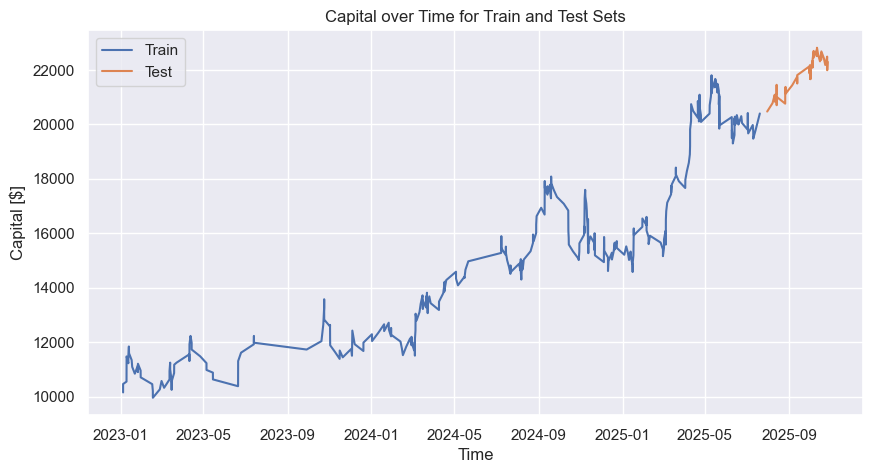


--- Model [rank=55, round=346] ---
Model [rank=55, round=346]  loaded.
leverage [-]:  8.269576962347873
Gain for one TP [$]:  307.9804229342824
Loss for one SL [$]:  -250.0
2024-12-12 13:00:00 is not in trade_signal
2024-12-12 13:00:00 is not in trade_signal
trade signal used, adding last buy & date_open


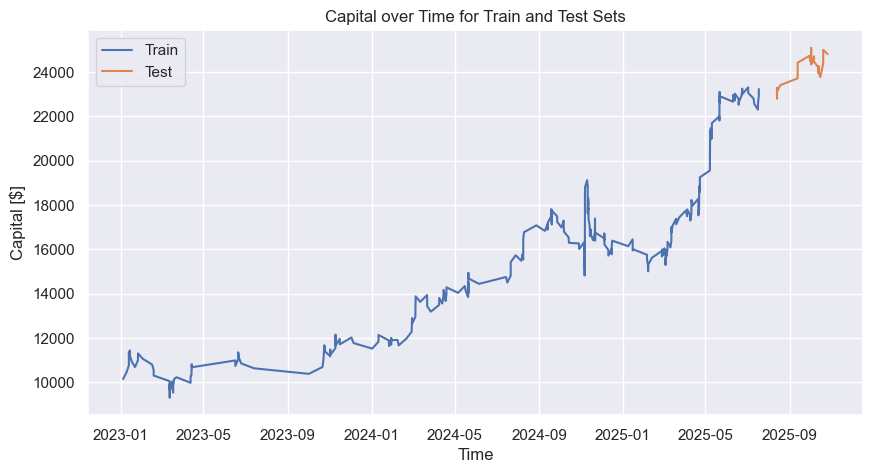


--- Model [rank=564, round=623] ---
Model [rank=564, round=623]  loaded.
leverage [-]:  8.269576962347873
Gain for one TP [$]:  307.9804229342824
Loss for one SL [$]:  -250.0
2024-12-12 13:00:00 is not in trade_signal
2024-12-12 13:00:00 is not in trade_signal
trade signal used, adding last buy & date_open


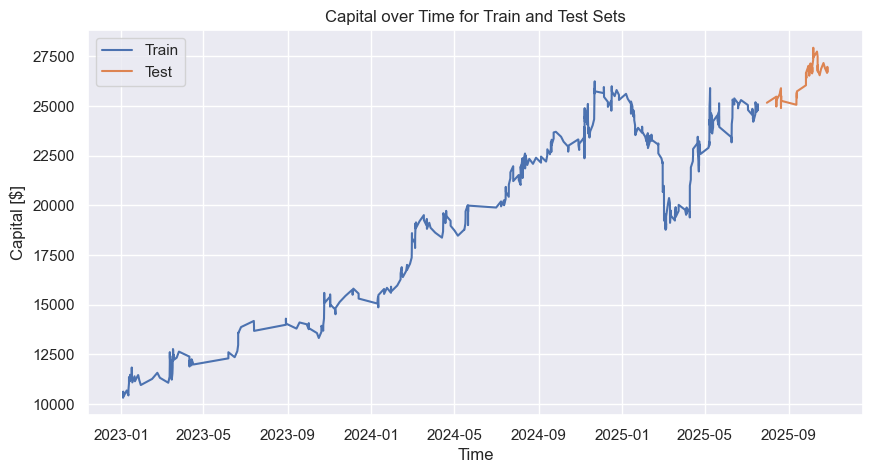


--- Model [rank=55, round=343] ---
Model [rank=55, round=343]  loaded.
leverage [-]:  8.269576962347873
Gain for one TP [$]:  307.9804229342824
Loss for one SL [$]:  -250.0
2024-12-12 13:00:00 is not in trade_signal
2024-12-12 13:00:00 is not in trade_signal
trade signal used, adding last buy & date_open


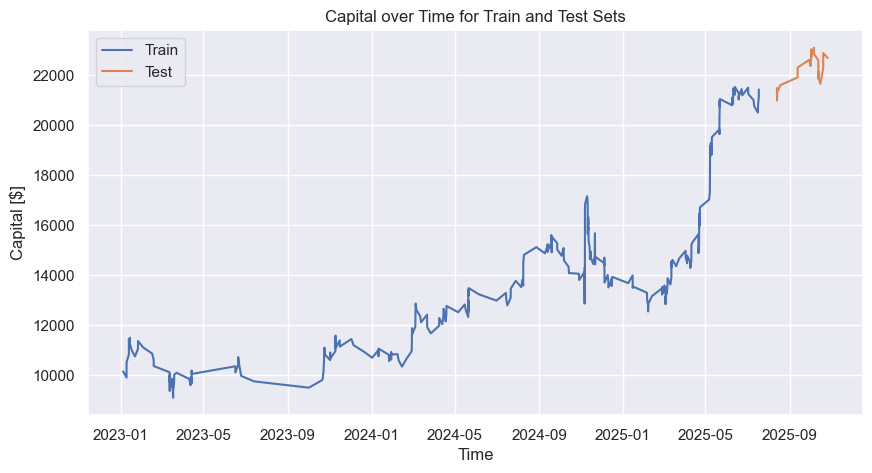


--- Model [rank=55, round=390] ---
Model [rank=55, round=390]  loaded.
leverage [-]:  8.269576962347873
Gain for one TP [$]:  307.9804229342824
Loss for one SL [$]:  -250.0
2024-12-12 13:00:00 is not in trade_signal
2024-12-12 13:00:00 is not in trade_signal
trade signal used, adding last buy & date_open


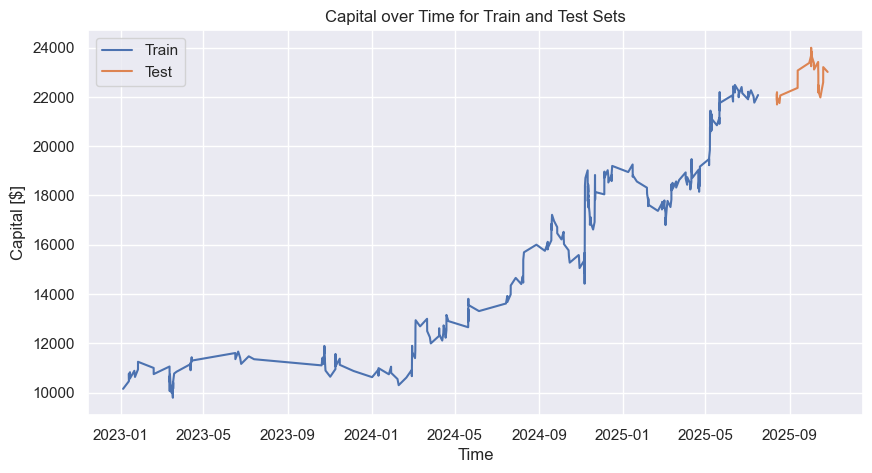

In [ ]:
for I in range(df_hcv_good.shape[0]):
        rank_best = int(df_hcv_good.iloc[I]["rank"])
        nb_rounds = int(df_hcv_good.iloc[I]["run_index"])
        print("\n--- Model [rank={}, round={}] ---".format(rank_best, nb_rounds))
        xgb_mdl_long = pickle.load(open(os.path.join(path_data,f'xgb_mdl_14_rank{rank_best}_round{nb_rounds}.pkl'), 'rb'))
        arr_xgb_pred_train = xgb_mdl_long.predict(df_combined_condition)
        arr_xgb_pred = xgb_mdl_long.predict(df_combined_condition_test)
        trade_signal_xgb = pd.Series(
                np.concatenate((arr_xgb_pred_train, arr_xgb_pred), axis=0), 
                index=df_feat_tot.index,
                name="xgb_pred",
        )
        df_trades, capital, nb_tp, nb_sl, nb_neutral, capital_tp, capital_sl, capital_neutral = (
        backtest(df_feat_tot, capital_init, step_max, 
                tp_ratio, risk_ratio, ratio_fees, R,
                trade_signal=trade_signal_xgb)
        )
        df_trades["Train"] = df_trades.index.isin(df_combined_condition.index)

        fig = plot_trading_performance(df_trades, df_feat_tot, monthly_target=gain_period_min)
        fig.show()
        # plot capital for train and test
        # plt.figure(figsize=(10, 5))
        # plt.plot(df_trades[df_trades["Train"]]["capital"], label="Train")
        # plt.plot(df_trades[~df_trades["Train"]]["capital"], label="Test")
        # plt.title("Capital over Time for Train and Test Sets")
        # plt.xlabel("Time")
        # plt.ylabel("Capital [$]")
        # plt.legend()
        # plt.grid(True)
        # plt.show()
        


In [203]:
# fig = plot_trading_performance(df_trades, df_feat_tot, monthly_target=333)
# fig.show()

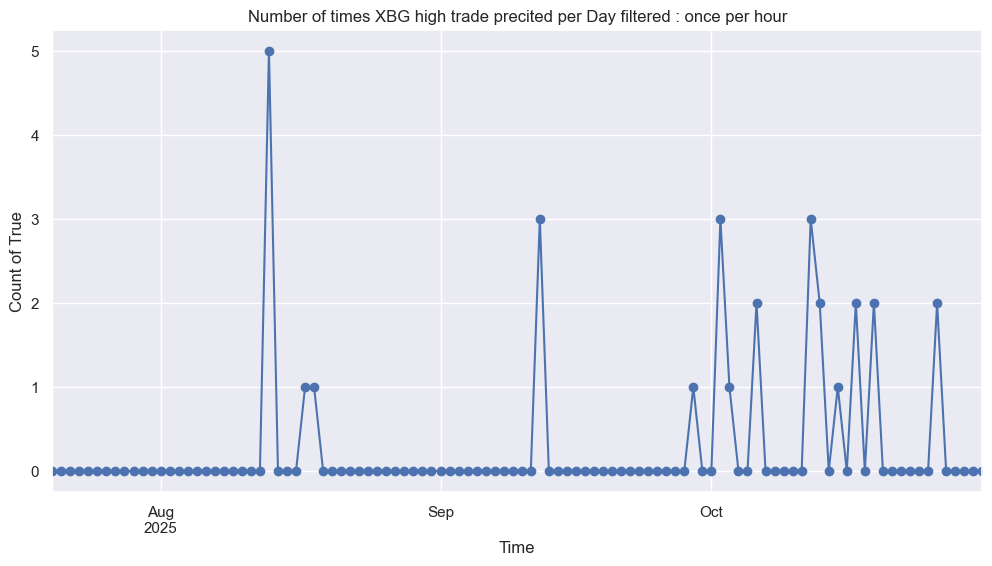

In [202]:
ser_xgb_pred = pd.Series(arr_xgb_pred, index=df_combined_condition_test.index)
ser_xgb_pred.resample("h").apply(sum_upfront_1h).resample("D").sum().plot(figsize=(12, 6), marker="o")
plt.title("Number of times XBG high trade precited per Day filtered : once per hour")
plt.xlabel("Time")
plt.ylabel("Count of True")
plt.grid(True)

In [61]:
ser_xgb_pred_nb = ser_xgb_pred.resample("h").apply(sum_upfront_1h).resample("D").sum()
print(f"Nb of trades high pred on Train: {ser_xgb_pred_nb.sum()} / {ser_xgb_pred_nb.shape[0]} days")
print(f"Nb of trades high pred per day ; {ser_xgb_pred_nb.sum() / ser_xgb_pred_nb.shape[0]:.2f}")
print(f"5-min samples leading to a high trade pred {ser_xgb_pred_nb.sum() / ser_xgb_pred.shape[0] * 100:.2f} % ")

Nb of trades high pred on Train: 109 / 104 days
Nb of trades high pred per day ; 1.05
5-min samples leading to a high trade pred 0.37 % 
